<a href="https://colab.research.google.com/github/EwoutH/Helsinki-flood-BEP-project/blob/main/road-graph/OSMnx_road_graph_analysis_BEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook 2 of 2, first part: https://colab.research.google.com/drive/1DE6MA7E2gOwGp7m35fzvrv5HQgdS3UQT

### Installation

Note that OSMnx is installed from my [own branch](https://github.com/EwoutH/osmnx/tree/edge-sum-refactor-2) with slight modification to the `travel_time` calculation. See [gboeing/osmnx#721](https://github.com/gboeing/osmnx/pull/721).

In [6]:
pip install -e git+https://github.com/EwoutH/osmnx.git@edge-sum-refactor-2#egg=OSMnx

Obtaining OSMnx from git+https://github.com/EwoutH/osmnx.git@edge-sum-refactor-2#egg=OSMnx
  Updating ./src/osmnx clone (to revision edge-sum-refactor-2)
  Running command git fetch -q --tags
  Running command git reset --hard -q b519b4bb178dce35c9197d227997e912b3ed401e
  Attempting uninstall: OSMnx
    Found existing installation: osmnx 1.1.1
    Uninstalling osmnx-1.1.1:
      Successfully uninstalled osmnx-1.1.1
  Running setup.py develop for OSMnx


In [7]:
pip install ./src/osmnx

Processing ./src/osmnx
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for osmnx: filename=osmnx-1.1.1-py3-none-any.whl size=93657 sha256=62a021166ddbc6f0ddfba3863bf73cc90f553c4cec32ff24e39899f2279ece92
  Stored in directory: /tmp/pip-ephem-wheel-cache-2sr2xrwg/wheels/08/e3/98/512ba9e140576c7ef7ad5f25a3ee979296ce9911caba1b4ac3
Successfully built osmnx
  Attempting uninstall: osmnx
    Found existing installation: osmnx 1.1.1
    Can't uninstall 'osmnx'. No files were found to uninstall.


In [8]:
pip install contextily

In [9]:
# Import packages
import networkx as nx
import geopandas as gpd
import contextily as cx
import pandas as pd
import numpy as np
import osmnx as ox
#import igraph as ig
import random

# Print versions
print(f'NetworkX version {nx.__version__}')
print(f'GeoPandas version {gpd.__version__}')
print(f'Pandas version {pd.__version__}')
print(f'NumPy version {np.__version__}')
print(f'OSMnx version {ox.__version__}')
#print(f'igraph version {ig.__version__}')

NetworkX version 2.5.1
GeoPandas version 0.9.0
Pandas version 1.1.5
NumPy version 1.19.5
OSMnx version 1.1.1


The following files are required:
* `road-graph-def.graphml`
* `TomTom-data-ext.csv`
* `TomTom-data-int.csv`
* `node-regions.csv`
* `edges-rain.csv`

Available on https://github.com/EwoutH/Helsinki-flood-BEP-project/tree/main/data

In [10]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir("drive/MyDrive/BEP Flood Resilience/Data")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Graph

In [11]:
# Load the MultiDiGraph and convert to DiGraph
ntypes = {'street_count': int, 'lon': float, 'lat': float, 'betw_cent': float}
etypes = {'min_lanes': int, 'oneway': bool, 'length': float, 'free_flow_speed': float,
          'free_flow_time': float, 'free_flow_capacity': int, 'edge_betw_cent': float}

G2b = ox.io.load_graphml('road-graph-def.graphml',edge_dtypes=etypes)
G2a = ox.utils_graph.get_digraph(G2b,weight='free_flow_time')

# Confirm network types
print(type(G2b))
print(type(G2a))

<class 'networkx.classes.multidigraph.MultiDiGraph'>
<class 'networkx.classes.digraph.DiGraph'>


In [12]:
# Load nodes and edges as GeoPandas Dataframes to be able to observe and plot them
nodes, edges = ox.graph_to_gdfs(G2b, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)
print(nodes["x"][5])

25498076.17910094


### Index and assign OD regions

In [13]:
# Some code to link each point to a region
noderegions = pd.read_csv('node-regions.csv', index_col=[0], skipinitialspace=True)
noderegions

,region,nodes,osmids,count
id,,,,
1,1,1254,2044,12
2,1,1373,784,12
3,1,1374,785,12
4,1,1375,1325,12
5,1,1376,1060,12
...,...,...,...,...
2583,199,1589,927,12
2584,199,1602,1896,12
2585,199,1719,1055,12


In [14]:
# Prepare the dataframe to be converted to a dictionary
noderegions2 = noderegions.set_index('osmids')
noderegions2 = noderegions2.drop(columns=['nodes', 'count'])
noderegions2.loc[noderegions2['region'] == 144]

,region
osmids,
0,144
140,144
1,144
142,144
112,144
113,144
1753,144
114,144
134,144


In [15]:
# Convert the Pandas dataframe to a dict
region_dict = noderegions2.to_dict('dict')['region']
print(region_dict)

{2044: 1, 784: 1, 785: 1, 1325: 1, 1060: 1, 786: 1, 1721: 1, 2100: 1, 2218: 1, 916: 1, 2045: 1, 935: 1, 484: 2, 485: 2, 954: 2, 920: 2, 921: 2, 1321: 2, 950: 2, 951: 2, 952: 2, 953: 2, 955: 2, 956: 2, 1485: 2, 1006: 3, 1007: 3, 1008: 3, 1010: 3, 1009: 3, 1011: 3, 1012: 3, 1030: 3, 1013: 3, 1014: 3, 1483: 3, 1029: 3, 1031: 3, 947: 4, 948: 4, 949: 4, 1001: 4, 998: 4, 999: 4, 1000: 4, 1002: 4, 1003: 4, 1924: 4, 1004: 4, 1005: 4, 793: 5, 342: 5, 735: 5, 1661: 5, 1654: 5, 346: 5, 782: 5, 883: 5, 842: 5, 733: 5, 734: 5, 1586: 5, 992: 6, 944: 6, 825: 6, 996: 6, 946: 6, 995: 6, 943: 6, 1834: 6, 990: 6, 991: 6, 993: 6, 997: 6, 341: 7, 1019: 7, 343: 7, 344: 7, 737: 7, 345: 7, 1662: 7, 736: 7, 739: 7, 738: 7, 2226: 7, 994: 7, 51: 8, 1282: 8, 1043: 8, 52: 8, 71: 8, 70: 8, 1016: 8, 867: 8, 1015: 8, 1042: 8, 1017: 8, 1018: 8, 49: 9, 1040: 9, 67: 9, 727: 9, 1039: 9, 90: 9, 709: 9, 717: 9, 718: 9, 1037: 9, 1038: 9, 1630: 9, 6: 10, 7: 10, 2482: 10, 46: 10, 1786: 10, 1025: 10, 779: 10, 2445: 10, 1024: 1

In [16]:
# Add region as a node attribute
nx.set_node_attributes(G2a, region_dict, 'region')
assert G2a.nodes[0]['region'] == 144

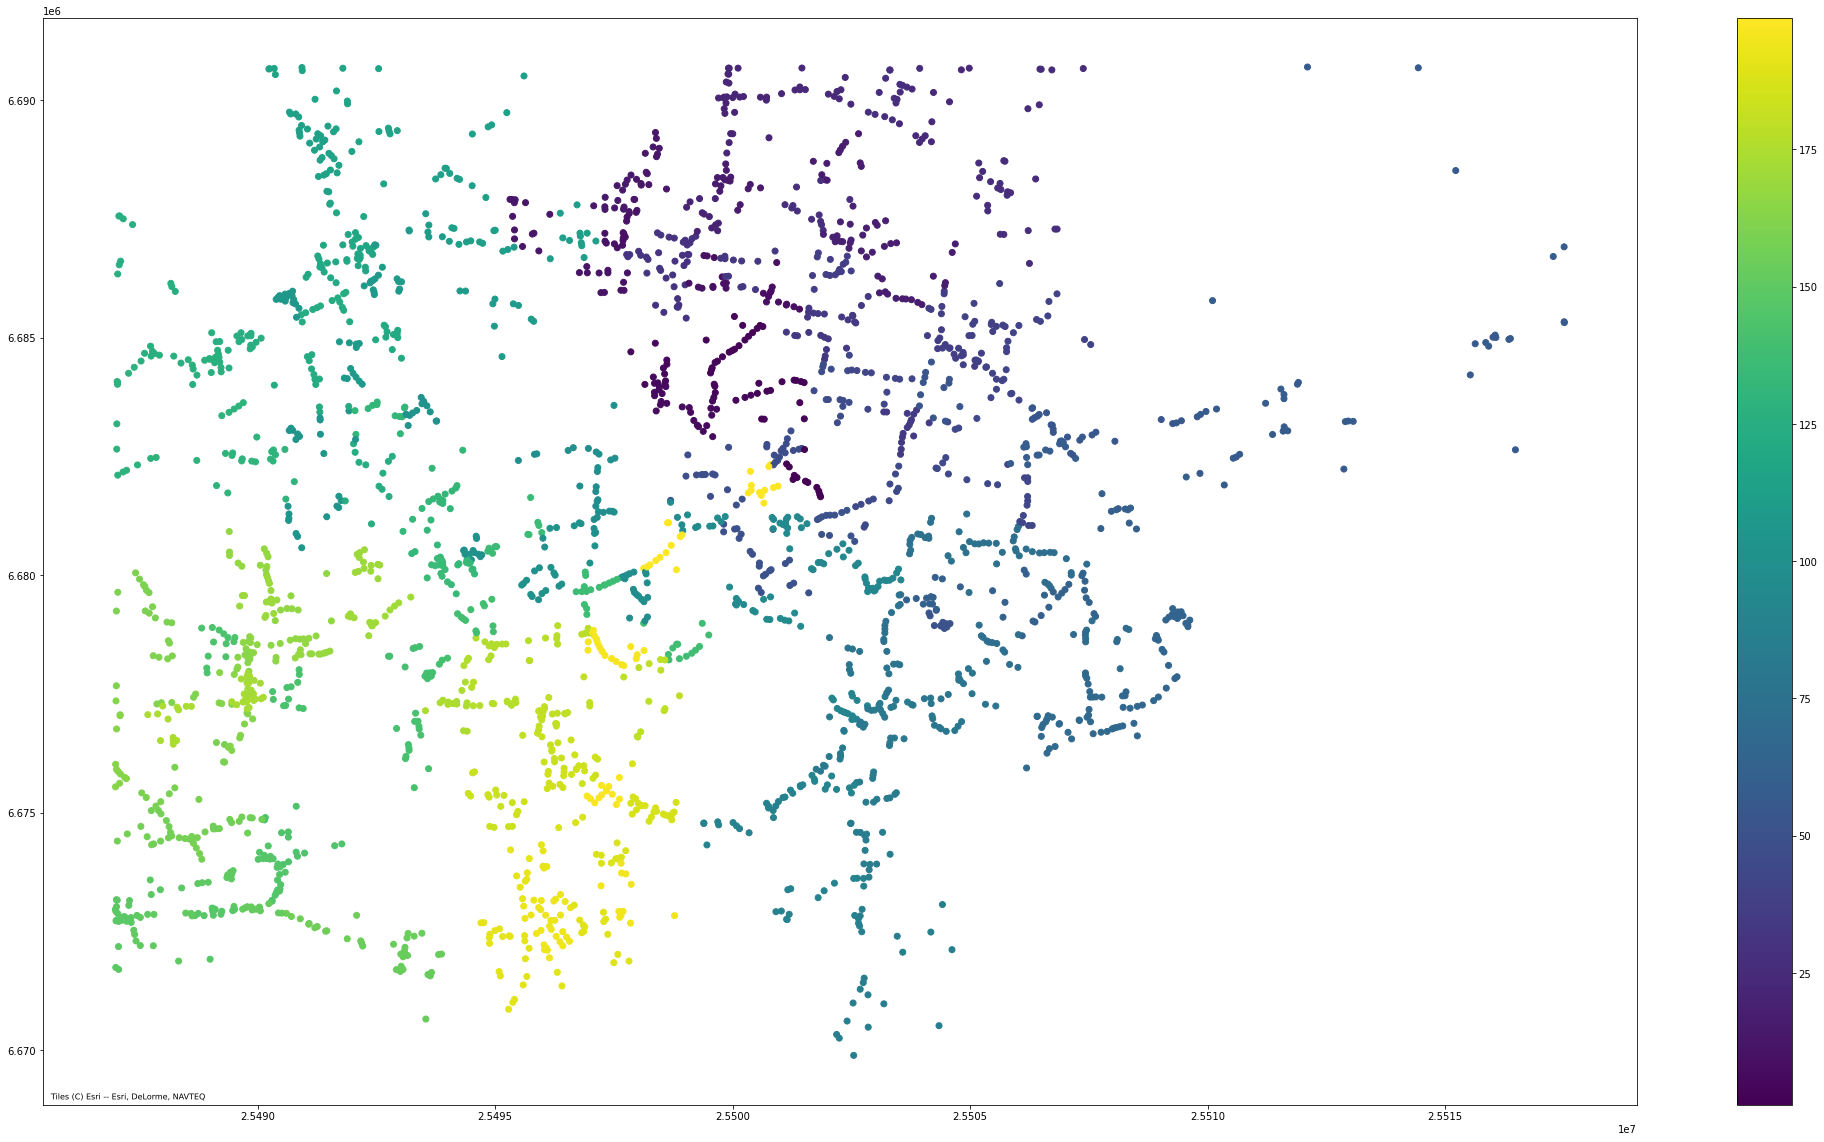

In [17]:
# Graph to see if clusting is correct
nodes2 = ox.graph_to_gdfs(G2a, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)
ax = nodes2.plot(column='region', figsize=(36,20), legend=True)
cx.add_basemap(ax, source=cx.providers.Esri.WorldGrayCanvas)
cx.add_basemap(ax, source=cx.providers.Esri.WorldGrayCanvas)

In [18]:
# Now the same steps for the count
nodecounts = noderegions.set_index('osmids')
nodecounts = nodecounts.drop(columns=['nodes', 'region'])

In [19]:
# Convert the Pandas dataframe to a dict
count_dict = nodecounts.to_dict('dict')['count']
print(count_dict)

{2044: 12, 784: 12, 785: 12, 1325: 12, 1060: 12, 786: 12, 1721: 12, 2100: 12, 2218: 12, 916: 12, 2045: 12, 935: 12, 484: 13, 485: 13, 954: 13, 920: 13, 921: 13, 1321: 13, 950: 13, 951: 13, 952: 13, 953: 13, 955: 13, 956: 13, 1485: 13, 1006: 13, 1007: 13, 1008: 13, 1010: 13, 1009: 13, 1011: 13, 1012: 13, 1030: 13, 1013: 13, 1014: 13, 1483: 13, 1029: 13, 1031: 13, 947: 12, 948: 12, 949: 12, 1001: 12, 998: 12, 999: 12, 1000: 12, 1002: 12, 1003: 12, 1924: 12, 1004: 12, 1005: 12, 793: 12, 342: 12, 735: 12, 1661: 12, 1654: 12, 346: 12, 782: 12, 883: 12, 842: 12, 733: 12, 734: 12, 1586: 12, 992: 12, 944: 12, 825: 12, 996: 12, 946: 12, 995: 12, 943: 12, 1834: 12, 990: 12, 991: 12, 993: 12, 997: 12, 341: 12, 1019: 12, 343: 12, 344: 12, 737: 12, 345: 12, 1662: 12, 736: 12, 739: 12, 738: 12, 2226: 12, 994: 12, 51: 12, 1282: 12, 1043: 12, 52: 12, 71: 12, 70: 12, 1016: 12, 867: 12, 1015: 12, 1042: 12, 1017: 12, 1018: 12, 49: 12, 1040: 12, 67: 12, 727: 12, 1039: 12, 90: 12, 709: 12, 717: 12, 718: 12

In [20]:
# Add count as a node attribute
nx.set_node_attributes(G2a, count_dict, 'count')
assert G2a.nodes[0]['count'] == 13

In [21]:
# Prepare the dataframe and convert to a dictionary
regioncounts = noderegions.set_index('region')
regioncounts = regioncounts.drop(columns=['nodes', 'osmids'])
region_counts = regioncounts.to_dict('dict')['count']
print(region_counts)
assert region_counts[144] == 13

{1: 12, 2: 13, 3: 13, 4: 12, 5: 12, 6: 12, 7: 12, 8: 12, 9: 12, 10: 15, 11: 12, 12: 13, 13: 15, 14: 16, 15: 16, 16: 12, 17: 15, 18: 12, 19: 13, 20: 12, 21: 12, 22: 15, 23: 13, 24: 12, 25: 12, 26: 16, 27: 16, 28: 12, 29: 14, 30: 12, 31: 12, 32: 12, 33: 13, 34: 12, 35: 16, 36: 12, 37: 15, 38: 16, 39: 13, 40: 12, 41: 12, 42: 12, 43: 12, 44: 12, 45: 12, 46: 14, 47: 16, 48: 12, 49: 12, 50: 12, 51: 12, 52: 12, 53: 12, 54: 12, 55: 12, 56: 12, 57: 16, 58: 12, 59: 16, 60: 12, 61: 12, 62: 12, 63: 12, 64: 13, 65: 12, 66: 12, 67: 12, 68: 12, 69: 15, 70: 12, 71: 12, 72: 13, 73: 12, 74: 12, 75: 12, 76: 12, 77: 14, 78: 12, 79: 13, 80: 12, 81: 12, 82: 12, 83: 12, 84: 12, 85: 12, 86: 12, 87: 12, 88: 14, 89: 12, 90: 12, 91: 15, 92: 16, 93: 13, 94: 16, 95: 17, 96: 12, 97: 19, 98: 14, 99: 13, 100: 14, 101: 12, 102: 12, 103: 13, 104: 12, 105: 12, 106: 16, 107: 12, 108: 12, 109: 12, 110: 12, 111: 12, 112: 12, 113: 13, 114: 17, 115: 13, 116: 12, 117: 12, 118: 16, 119: 12, 120: 13, 121: 12, 122: 12, 123: 13, 

In [22]:
# Benchmarks
import timeit

print(timeit.timeit(lambda: G2a.nodes[5]['region'], number=10000))
print(timeit.timeit(lambda: region_dict[5], number=10000))

print(timeit.timeit(lambda: G2a.nodes[0]['count'], number=10000))
print(timeit.timeit(lambda: region_counts[144], number=10000))

0.011112175999983265
0.0017559860000346816
0.011480308999978206
0.0012768039999855318


### OD data

In [23]:
# Import of TomTom OD data as MultiIndexed 
tte = pd.read_csv('TomTom-data-ext.csv', index_col=[0,1], skipinitialspace=True)
tti = pd.read_csv('TomTom-data-int.csv', index_col=[0,1], skipinitialspace=True)

In [24]:
# For the internal dataset, drop the "External" rows and convert index to integers
tti = tti.drop(labels='External')
tti = tti.drop(labels='External', level=1)
i0 = tti.index.get_level_values(0).astype(int)
i1 = tti.index.get_level_values(1).astype(int)
tti.index = [i0,i1]
tti

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


All  Night  Day  Evening
Origin Destination                          
1      1            119      1  109       23
       2             54      1   38       16
       3              4      0    4        0
       4             13      0   11        3
       5             15      0   14        2
...                 ...    ...  ...      ...
199    195           51      2   31       16
       196           62      0   45       17
       197           70      8   49       11
       198           95      3   70       27
       199          415     39  306      109

[39601 rows x 4 columns]

In [25]:
tte_dict = tte["All"].to_dict()
tti_dict = tti["All"].to_dict()

In [26]:
# Print some validation
print(tte.loc[(1, 1), "All"])
print(tte.at[(1, 1), "All"])
print(tte._get_value(0, 0, "All"))
print(tte_dict[(1, 1)])

# Small benchmark
print(timeit.timeit(lambda: tte.loc[(1, 1), "All"], number=10000))
print(timeit.timeit(lambda: tte.at[(1, 1), "All"], number=10000))
print(timeit.timeit(lambda: tte._get_value(1-1, 1-1, "All"), number=10000))
print(timeit.timeit(lambda: tte_dict[(1, 1)], number=10000))

116
116
116
116
2.1248192079999626
0.1718001229999686
0.21477404000000888
0.0018368979999650037


In [27]:
# Global OD-data switch
tt_od = tte
tt_od_s = 'tte'

### Add rain depths to edges

In [28]:
# Add rain depth stats (max, mean, length) for edges
edgesrain = pd.read_csv('edges-rain.csv', index_col=[1,2,3], skipinitialspace=True)
edgesrain = edgesrain.fillna(0)
print(edgesrain)

               OID_  ... ZLength198mm
u    v    key        ...             
0    140  0       1  ...     0.000000
     1    0       2  ...     0.000000
140  143  0       3  ...   189.905234
     2470 0       4  ...     9.753023
     134  0       5  ...     0.000000
...             ...  ...          ...
2565 2566 0    5505  ...     0.000000
2579 792  0    5506  ...   110.702920
2584 2583 0    5507  ...     0.000000
     2585 0    5508  ...     0.000000
2585 1781 0    5509  ...     0.000000

[5509 rows x 21 columns]


Possible speed formulas:
 - `85*e^(-9x)` (x depth in meters) ([Choo et al., 2020](https://www.mdpi.com/2073-4441/12/4/926))
 - `0.0009w^2-0.5529w+86.9448` (w depth in millimeters) ([Pregnalato et al., 2017](https://www.sciencedirect.com/science/article/pii/S1361920916308367))

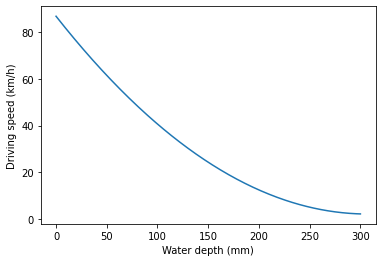

In [29]:
import matplotlib.pyplot as plt
xp = np.array(range(0, 301))
yp = 0.0009*xp**2-0.5529*xp+86.9448
plt.plot(xp, yp)
plt.xlabel('Water depth (mm)')
plt.ylabel('Driving speed (km/h)')
#plt.savefig("Water-depth-driving-speed.svg", format='svg')
plt.show()

### The functions

In [30]:
import itertools
import gc
from collections import defaultdict

In [31]:
def speed_function(wd, formula='Pregnalato'):
  if formula == 'Pregnalato':
    wd = wd * 1000
    return 0.0009*wd**2-0.5529*wd+86.9448

  elif formula == 'Choo':
    return 85*wd**(-9*wd)
  else:
    print('Unknow depth-speed formula. Implemented: "Pregnalato", "Choo".')

In [32]:
def prepare_graph(graph, drivable_depth=0.30, rain=[44, 54, 71, 86, 20, 198]):
  # Convert the DiGraph to MultiDiGraph (for OSMnx)
  if type(graph) is nx.classes.digraph.DiGraph:
    graph = nx.MultiDiGraph(graph)
  elif type(graph) is not nx.classes.multidigraph.MultiDiGraph:
    print('Unsupported graph type. Input NetworkX DiGraph or MultiDiGraph.')

  # Save the nodes and edges as GeoPandas DataFrame
  nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)

  ed = {}      # Empty dict for edges
  for i in rain:
    # Save the edges as GeoPandas DataFrame
    ed[str(i)] = ox.graph_to_gdfs(graph, nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)

    # Add flood levels to edges dataframe
    ed[str(i)] = pd.concat([ed[str(i)], edgesrain.filter(regex=f'{rain}mm')], axis=1)

    # Select edges which are drivable
    ed[str(i)] = ed[str(i)][ed[str(i)][f'ZMax{i}mm'] <= drivable_depth]

    # Save the old free flow time
    ed[str(i)]['orig_free_flow_time'] = ed[str(i)]['free_flow_time']

    # Calculate speed on flooded segment (min of free flow speed and flooded speed from function)
    ed[str(i)]['reduced_speed'] = pd.concat([speed_function(ed[str(i)][f'ZMean{i}mm']), ed[str(i)]['free_flow_speed']], axis=1).min(axis=1)

    # Calculate the new free flow time
    ed[str(i)]['free_flow_time'] = ed[str(i)][f'ZLength{i}mm'] / (ed[str(i)]['reduced_speed'] / 3.6) + (ed[str(i)]['length'] - ed[str(i)][f'ZLength{i}mm']) / (ed[str(i)]['free_flow_speed'] / 3.6)

  gm_dict = {} # Empty dict for MultiDiGraphs
  gb_dict = {} # Empty dict for DiGraphs

  # Create graphs from edge dictionaries
  for k,v in ed.items():
    gm_dict[k] = ox.utils_graph.graph_from_gdfs(nodes, v)
    gb_dict[k] = ox.utils_graph.get_digraph(gm_dict[k], weight='free_flow_time')

  return gb_dict

In [33]:
def analyse_graph(graph, od_area=tt_od, od_time="All", prints=True):
  # Calcualte the paths lengths of all reachable pairs
  reachable_path_lengths = dict(nx.all_pairs_dijkstra_path_length(graph, cutoff=None, weight="free_flow_time"))

  # Create empty dictionaries
  od_weights = {}         # The length and OD weight for each trip
  od_weights_region = {}  # The OD weights between each region. For validation.

  tt_dict = od_area[od_time].to_dict()  # Select TomTom OD data and convert to dictionary

  for origin,d in reachable_path_lengths.items():
    ro = region_dict[origin]
    for destination, length in d.items():
      rd = region_dict[destination]
      trips = tt_dict[(ro, rd)]
      weight = trips / (region_counts[ro]*region_counts[rd])

      od_weights[(origin,destination)] = (length, weight) 
      #od_weights_region[(ro,rd)] = od_weights_region.get((ro,rd), 0) + weight

  # Calculate some stats
  number_nodes = graph.number_of_nodes()             # Number of nodes in the graph
  number_edges = graph.number_of_edges()             # Number of nodes in the graph
  trip_count = sum(tt_dict.values())                 # Sum of all trips in the OD-matrix
  total_travel_time = sum([i[0]*i[1] for i in od_weights.values()])      # Total weighted travel time (s)
  route_count = len(od_weights)                      # All possible routes between nodes
  possible_weight = sum([i[1] for i in od_weights.values()])
  mean_travel_time = total_travel_time / possible_weight

  if prints:
    print(f'{possible_weight:.1f} trips on {route_count} routes took {total_travel_time:.1f} seconds, {mean_travel_time:.3f} s on average')
    print(f'{number_nodes**2} possible node combinations, {route_count} available paths and {number_nodes**2-route_count} not available ({(route_count/number_nodes**2)*100:.3f}%)')

  # Calculate OD weights for impossible routes
  node_combinations = list(itertools.product(range(graph.number_of_nodes()), repeat=2))
  possible_combinations = list(od_weights)    # list(dict) takes only the keys
  impossible_combinations = list(set(node_combinations) - set(possible_combinations))
  isolated_nodes = nx.number_of_isolates(graph)

  impossible_paths = {}
  for o,d in impossible_combinations:
    ro = region_dict[o]
    rd = region_dict[d]
    trips = tt_dict[(ro, rd)]
    weight = trips / (region_counts[ro]*region_counts[rd])
    impossible_paths[(o,d)] = weight
  
  # Stats
  impossible_weight = sum(impossible_paths.values())

  if prints:
    print(f'Weight of possible trips: {possible_weight:.2f}, weight of impossible trips: {impossible_weight:.2f}, percentage impossible: {impossible_weight/(possible_weight+impossible_weight)*100:.3f}%')
    print(f'Isolated nodes: {isolated_nodes}, percentage: {100*isolated_nodes/number_nodes:.2f}%\n')

  return_dict = {
      'mean_travel_time': mean_travel_time,
      'stats': [possible_weight, total_travel_time, mean_travel_time, route_count, number_nodes**2-route_count, impossible_weight, trip_count, number_nodes, isolated_nodes, number_edges],
      'impossible_paths': impossible_paths,
      'od_weights': od_weights,
  }

  return return_dict

In [34]:
def od_centrality(graph,  stats):
  # Convert the DiGraph to MultiDiGraph (for OSMnx)
  if type(graph) is nx.classes.digraph.DiGraph:
    graph = nx.MultiDiGraph(graph)
  elif type(graph) is not nx.classes.multidigraph.MultiDiGraph:
    print('Unsupported graph type. Input NetworkX DiGraph or MultiDiGraph.')

  # Save the nodes and edges as GeoPandas DataFrame
  nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

  paths = dict(nx.all_pairs_dijkstra_path(graph, cutoff=None, weight="free_flow_time"))

  # Get all possible paths in a tuple-keyed dictionary
  combis = {}
  for origin,d in paths.items():
    for destination, path in d.items():
      combis[(origin, destination)] = path
  
  # Calculated the OD-weighted centrality
  weighted_centrality_dict = defaultdict(float)
  for od, path in combis.items():
    od_weight = stats["od_weights"][od][1] # [1] selects the weight in the tuple
    for edge in list(zip(path, path[1:], np.zeros((len(path)), dtype=int))):
      weighted_centrality_dict[edge] += od_weight

  # Add OD centrality values to edges dataframe
  edges["weighted_centrality"] = pd.Series(weighted_centrality_dict)
  edges["weighted_centrality"].fillna(0)

  # Generate new NetworkX MultiDiGraph from nodes and edges and convert to DiGraph
  graph_m = ox.utils_graph.graph_from_gdfs(nodes, edges)
  graph_d = ox.utils_graph.get_digraph(graph_m, weight='free_flow_time')
  return graph_d

### Create table at which level each road floods

In [128]:
# Create dictionary of flooded graphs
rain = [44, 54, 71, 86, 20, 198]
flooded_graphs = prepare_graph(G2a, drivable_depth=0.30, rain=rain)

In [129]:
# Create new dataframe for edges with ZMax levels
ZMaxDf = edges[['name', 'highway']].copy()
MaxS = {}
for i in rain:
  ZMaxS[str(i)] = ox.graph_to_gdfs(nx.MultiDiGraph(flooded_graphs[str(i)]), nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)[f'ZMax{i}mm']
  ZMaxDf[f'ZMax{i}mm'] = ZMaxS[str(i)]

In [130]:
rain = [20, 44, 54, 71, 86, 198]

def flooded_level(df):
  df = df.assign(flooded=None)
  for i in rain[::-1]:
    df.loc[df[f'ZMax{i}mm'].isnull(), 'flooded'] = i
  return df

ZMaxDf = flooded_level(ZMaxDf)

In [131]:
ZMaxDf['flooded'].value_counts()

20     364
44     129
198    103
54      35
86      27
71      27
Name: flooded, dtype: int64

In [132]:
ZMaxDf.to_csv(f'edges-when-flooded.csv')

### Comparing scenarios

 - Average travel time increase [s/s = %] for identical set of routes
 - Routes with their weights [{dict}] not possible, as percentage of all [n/n = %]
 - Impact of removing individual edges and their effect on total travel time
 - Removing combinations of individual edges and measuring their impact on total travel time. selection on highest travel time impact or centrality

In [ ]:
default_stats = analyse_graph(G2a)

1911281.3 trips on 6505175 routes took 939415372.5 seconds, 491.511 s on average
6692569 possible node combinations, 6505175 available paths and 187394 not available (97.200%)
Weight of possible trips: 1911281.25, weight of impossible trips: 137566.75, percentage impossible: 6.714%
Isolated nodes: 0, percentage: 0.00%



In [ ]:
flooded_stats = {}
for i in rain:
  print(f'### Stats for {i} mm rain ###')
  flooded_stats[str(i)] = analyse_graph(flooded_graphs[str(i)])
  flooded_graphs[str(i)] = od_centrality(flooded_graphs[str(i)], flooded_stats[str(i)])
  gc.collect()

### Stats for 44 mm rain ###
1630934.1 trips on 5102003 routes took 1159744172.5 seconds, 711.092 s on average
6692569 possible node combinations, 5102003 available paths and 1590566 not available (76.234%)
Weight of possible trips: 1630934.08, weight of impossible trips: 417913.92, percentage impossible: 20.398%
Isolated nodes: 46, percentage: 1.78%

### Stats for 54 mm rain ###
1595542.2 trips on 4873833 routes took 1396854193.7 seconds, 875.473 s on average
6692569 possible node combinations, 4873833 available paths and 1818736 not available (72.825%)
Weight of possible trips: 1595542.23, weight of impossible trips: 453305.77, percentage impossible: 22.125%
Isolated nodes: 54, percentage: 2.09%

### Stats for 71 mm rain ###
1582734.3 trips on 4807291 routes took 1399224387.6 seconds, 884.055 s on average
6692569 possible node combinations, 4807291 available paths and 1885278 not available (71.830%)
Weight of possible trips: 1582734.34, weight of impossible trips: 466113.66, percenta

In [ ]:
G3a = od_centrality(G2a, default_stats)
gc.collect()

0

In [ ]:
# Be able to iterate through rain values including 0
rain = [0, 44, 54, 71, 86, 20, 198]
flooded_graphs[str(0)] = G3a
flooded_stats[str(0)] = default_stats

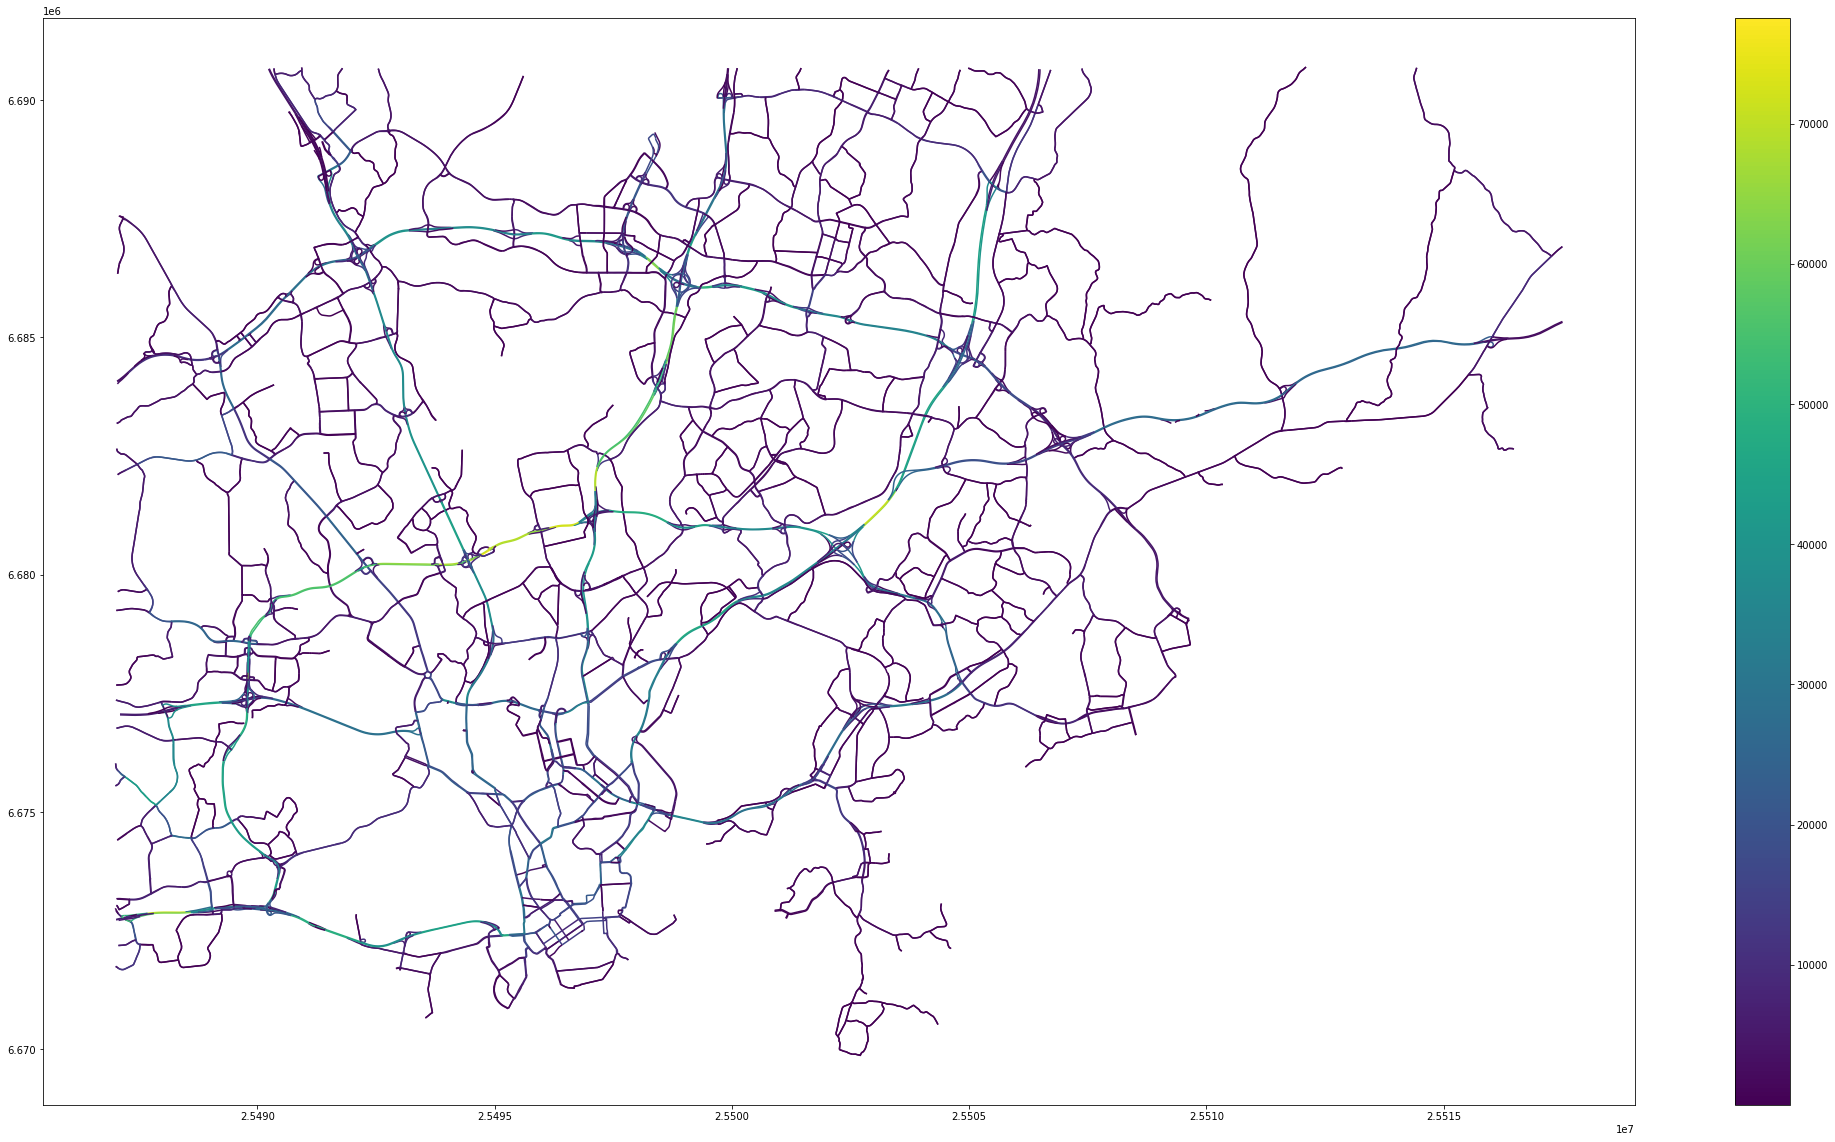

In [ ]:
# Plot the OD weighted betweenness centrality of the edges
G3b = nx.MultiDiGraph(G3a)
edges = ox.graph_to_gdfs(G3b, nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)
ax = edges.plot(column="weighted_centrality", figsize=(36,20), legend=True)
cx.add_basemap(ax, source=cx.providers.Esri.WorldGrayCanvas)
plt.savefig("Weighted-centrality-map.svg", format='svg')

### Mean travel time comparison

In [ ]:
# Compares the mean travel time between identical sets of routes
def compare_travel_time(stats, rain, stats_def=default_stats):
  # Calculate the total travel time for routes in both graphs (lengths * weights)
  def_tt = sum([j[0]*j[1] for i,j in stats_def["od_weights"].items() if i in stats["od_weights"].keys()])

  # Calculate the weight for routes in both graphs (weights)
  def_w = sum([j[1] for i,j in stats_def["od_weights"].items() if i in stats["od_weights"].keys()])

  # Calculate the mean travel time
  def_mean_tt = def_tt / def_w

  # Print and return the output
  if rain > 0:
    print(f'Mean travel time on identical set of routes: {def_mean_tt:.3f} s, with {rain}mm rain: {stats["mean_travel_time"]:.3f}')
  return def_mean_tt

In [ ]:
print(f'Mean travel time with all routes: {default_stats["mean_travel_time"]:.3f} s')
flooded_stats[str(0)]["mean_travel_time_id"] = default_stats["mean_travel_time"]

for i in rain[1:]:
  flooded_stats[str(i)]["mean_travel_time_id"] = compare_travel_time(flooded_stats[str(i)], i)

Mean travel time with all routes: 491.511 s
Mean travel time on identical set of routes: 486.333 s, with 44mm rain: 711.092
Mean travel time on identical set of routes: 486.142 s, with 54mm rain: 875.473
Mean travel time on identical set of routes: 486.163 s, with 71mm rain: 884.055
Mean travel time on identical set of routes: 486.292 s, with 86mm rain: 1069.397
Mean travel time on identical set of routes: 488.838 s, with 20mm rain: 616.089
Mean travel time on identical set of routes: 486.419 s, with 198mm rain: 1088.825


In [ ]:
flooded_stats_dict = {}
for i in rain:
  flooded_stats_dict[i] = flooded_stats[str(i)]['stats'] + [flooded_stats[str(i)]['mean_travel_time_id']]
  
flooded_stats_df = pd.DataFrame.from_dict(flooded_stats_dict, orient='index', columns=['Trips possible' , 'Total travel time', 'Mean Travel time', 'Available paths', 'Unavailable paths', 'Trips impossible', 'Trips total', 'Nodes', 'Isolated nodes', 'Edges', 'Mean travel time (id. set)'])
#flooded_stats_df.to_csv(f'flooded_stats-{tt_od_s}-rs.csv')
flooded_stats_df.round(2)

,Trips possible,Total travel time,Mean Travel time,Available paths,Unavailable paths,Trips impossible,Trips total,Nodes,Isolated nodes,Edges,Mean travel time (id. set)
0,1911281.25,9.394154e+08,491.51,6505175,187394,137566.75,2048848,2587,0,5509,491.51
44,1630934.08,1.159744e+09,711.09,5102003,1590566,417913.92,2048848,2587,46,5016,486.33
54,1595542.23,1.396854e+09,875.47,4873833,1818736,453305.77,2048848,2587,54,4981,486.14
71,1582734.34,1.399224e+09,884.06,4807291,1885278,466113.66,2048848,2587,60,4955,486.16
86,1569241.93,1.678142e+09,1069.40,4747833,1944736,479606.07,2048848,2587,65,4928,486.29
20,1767732.77,1.089080e+09,616.09,5814948,877621,281115.23,2048848,2587,31,5145,488.84
198,1487353.76,1.619468e+09,1088.83,4371129,2321440,561494.24,2048848,2587,100,4825,486.42


### OD-weighted centrality comparison

In [ ]:
def compare_od_centrality(n=6, rain=rain):
  od_dict = {}
  high_centrality = []
  edge_data = {}
  for j in rain:
    # Get weighted centrality edges values in a dictionary
    od_dict[str(j)] = nx.get_edge_attributes(flooded_graphs[str(j)], "weighted_centrality")

    # Create a list with the n highest weighted_centrality values for each rain value
    high = sorted(od_dict[str(j)], key=od_dict[str(j)].get, reverse=True)[:n]
    for edge in high:
        if edge not in high_centrality:
            high_centrality.append(edge)

    # Get all the edge weighted centrality values into a dictionary
    edge_data[j] = flooded_graphs[str(j)].edges

  # Add the weighted centrality values for determined list of edges to dictionaries
  od_cent = {}
  for i in high_centrality:
    od_cent[i] = [edge_data[j][i]["weighted_centrality"] if i in edge_data[j].keys() else 0.0 for j in rain]

  # Return and PandasDataframe with the OD-centrality values for each edge and rain value
  return pd.DataFrame.from_dict(od_cent, orient='index', columns=rain)

In [ ]:
compare_od_centrality(3).round(2)

,0,44,54,71,86,20,198
"(1459, 1464)",77572.32,40.19,5.27,5.27,5.27,49941.61,2.60
"(1794, 131)",72298.20,17447.20,27451.58,27234.85,27872.35,45625.78,16.58
"(589, 2251)",72268.25,7.69,7.69,7.69,7.69,21732.86,0.00
"(1706, 1705)",21136.20,153855.54,192967.65,187785.26,190486.73,124931.78,179041.57
"(1705, 1704)",16595.57,150158.25,189588.31,184455.19,186396.31,122442.82,175059.08
"(836, 1779)",13194.74,105028.67,135858.97,131619.69,17337.71,73021.81,16992.78
"(1755, 13)",40603.94,63210.94,203088.63,200741.55,262006.19,76915.58,251911.86
"(71, 70)",41479.05,88047.78,202062.51,200821.85,57693.51,37422.50,52044.87
"(1047, 71)",13102.09,88014.93,202035.70,200796.79,57668.52,37396.14,52013.44
"(91, 987)",39609.87,63424.78,200803.87,198489.27,259664.12,78301.76,249660.85


In [ ]:
# This function selects the n highest _differences_ in OD-centrality after edge removal
def compare_od_centrality_removed(n=6, z=198, rain=rain):
  od_dict = {}
  for j in rain:
    # Get weighted centrality edges values in a dictionary
    od_dict[str(j)] = nx.get_edge_attributes(flooded_graphs[str(j)], "weighted_centrality")

  high_centrality = []
  edge_data = {}
  for j in rain:
    # Create a list with the n highest weighted_centrality values for each rain value
    high = sorted(od_dict[str(j)], key=od_dict[str(j)].get, reverse=True)
    high = [i for i in high if i in flooded_stats[str(z)]["impossible_paths"].keys()][:n]
    for edge in high:
        if edge not in high_centrality:
            high_centrality.append(edge)

    # Get all the edge weighted centrality values into a dictionary
    edge_data[j] = flooded_graphs[str(j)].edges

  # Add the weighted centrality values for determined list of edges to dictionaries
  od_cent = {}
  for i in high_centrality:
    od_cent[i] = [edge_data[j][i].get("weighted_centrality",0.0) if i in edge_data[j].keys() else 0.0 for j in rain]

  # Return and PandasDataframe with the OD-centrality values for each edge and rain value
  return pd.DataFrame.from_dict(od_cent, orient='index', columns=rain)

In [ ]:
n = 12
central_flooded_edges = compare_od_centrality_removed(n, 198)
print(list(central_flooded_edges.index))
#central_flooded_edges.to_csv(f'central_flooded_edges-{n}-{tt_od_s}-rs.csv')
central_flooded_edges.round(2)

[(589, 2251), (218, 206), (1463, 130), (214, 1409), (2251, 218), (540, 17), (130, 1794), (127, 128), (1413, 126), (1409, 540), (18, 1977), (1762, 1851), (1777, 314), (1543, 1777), (1039, 1038), (49, 1040), (150, 153), (1687, 35), (1636, 159), (1638, 1342), (149, 150), (165, 160), (381, 331), (331, 1688), (956, 957), (957, 1256), (919, 920), (918, 919), (941, 918), (2392, 1717), (1717, 2530), (146, 2515), (1827, 1794), (576, 1222), (1742, 841), (2201, 216), (1763, 233), (208, 2201), (209, 2201), (1402, 1401), (515, 1402), (2201, 209), (2194, 2514), (281, 280), (1635, 12), (35, 36), (2514, 149), (38, 43), (43, 42), (516, 814), (1448, 588)]


,0,44,54,71,86,20,198
"(589, 2251)",72268.25,7.69,7.69,7.69,7.69,21732.86,0.0
"(218, 206)",69786.68,42691.41,0.00,0.00,0.00,33710.08,0.0
"(1463, 130)",68379.21,0.00,0.00,0.00,0.00,50185.31,0.0
"(214, 1409)",67905.64,0.00,0.00,0.00,0.00,45726.70,0.0
"(2251, 218)",64689.51,0.00,0.00,0.00,0.00,21784.40,0.0
"(540, 17)",64657.70,0.00,0.00,0.00,0.00,42125.22,0.0
"(130, 1794)",63974.76,0.00,0.00,0.00,0.00,0.00,0.0
"(127, 128)",61721.49,6753.42,0.00,0.00,0.00,50252.53,0.0
"(1413, 126)",60359.47,0.00,0.00,0.00,0.00,49059.17,0.0
"(1409, 540)",60333.27,1.31,1.31,1.31,0.00,39569.51,0.0


### Remove single edges

In [ ]:
high_risk_stats = {}
for i in list(central_flooded_edges.index):
  print(f'### Stats for edge {i} removed ###')
  # Copy graph and remove edge
  graph = G3a.copy()
  graph.remove_edge(*i)

  # Analyse graph and calculate stats
  stats = analyse_graph(graph, prints=False)
  stats["stats"].append(compare_travel_time(stats, 0))
  high_risk_stats[i] = stats["stats"]
  gc.collect()

### Stats for edge (589, 2251) removed ###
### Stats for edge (218, 206) removed ###
### Stats for edge (1463, 130) removed ###
### Stats for edge (214, 1409) removed ###
### Stats for edge (2251, 218) removed ###
### Stats for edge (540, 17) removed ###
### Stats for edge (130, 1794) removed ###
### Stats for edge (127, 128) removed ###
### Stats for edge (1413, 126) removed ###
### Stats for edge (1409, 540) removed ###
### Stats for edge (18, 1977) removed ###
### Stats for edge (1762, 1851) removed ###
### Stats for edge (1777, 314) removed ###
### Stats for edge (1543, 1777) removed ###
### Stats for edge (1039, 1038) removed ###
### Stats for edge (49, 1040) removed ###
### Stats for edge (150, 153) removed ###
### Stats for edge (1687, 35) removed ###
### Stats for edge (1636, 159) removed ###
### Stats for edge (1638, 1342) removed ###
### Stats for edge (149, 150) removed ###
### Stats for edge (165, 160) removed ###
### Stats for edge (381, 331) removed ###
### Stats for edge

In [ ]:
hre_stats_df = pd.DataFrame.from_dict(high_risk_stats, orient='index', columns=['Trips possible' , 'Total travel time', 'Mean Travel time', 'Available paths', 'Unavailable paths', 'Trips impossible', 'Trips total', 'Nodes', 'Isolated nodes', 'Edges', 'Mean travel time (id. set)'])
#hre_stats_df.to_csv(f'hr-edges-stats-{n}-{tt_od_s}-rs.csv')
hre_stats_df.round(2)

,Trips possible,Total travel time,Mean Travel time,Available paths,Unavailable paths,Trips impossible,Trips total,Nodes,Isolated nodes,Edges,Mean travel time (id. set)
"(589, 2251)",1910028.80,9.473154e+08,495.97,6500077,192492,138819.20,2048848,2587,0,5508,491.54
"(218, 206)",1909862.51,9.480145e+08,496.38,6500077,192492,138985.49,2048848,2587,0,5508,491.53
"(1463, 130)",1909862.51,9.483358e+08,496.55,6500077,192492,138985.49,2048848,2587,0,5508,491.54
"(214, 1409)",1909935.42,9.466069e+08,495.62,6497532,195037,138912.58,2048848,2587,0,5508,491.52
"(2251, 218)",1911281.25,9.407524e+08,492.21,6505175,187394,137566.75,2048848,2587,0,5508,491.51
"(540, 17)",1910018.25,9.454457e+08,494.99,6500077,192492,138829.75,2048848,2587,0,5508,491.49
"(130, 1794)",1911281.25,9.397463e+08,491.68,6505175,187394,137566.75,2048848,2587,0,5508,491.51
"(127, 128)",1910437.18,9.459597e+08,495.15,6500077,192492,138410.82,2048848,2587,0,5508,491.52
"(1413, 126)",1909182.14,9.425915e+08,493.71,6497527,195042,139665.86,2048848,2587,0,5508,491.48
"(1409, 540)",1911281.25,9.410843e+08,492.38,6505175,187394,137566.75,2048848,2587,0,5508,491.51


### Plots

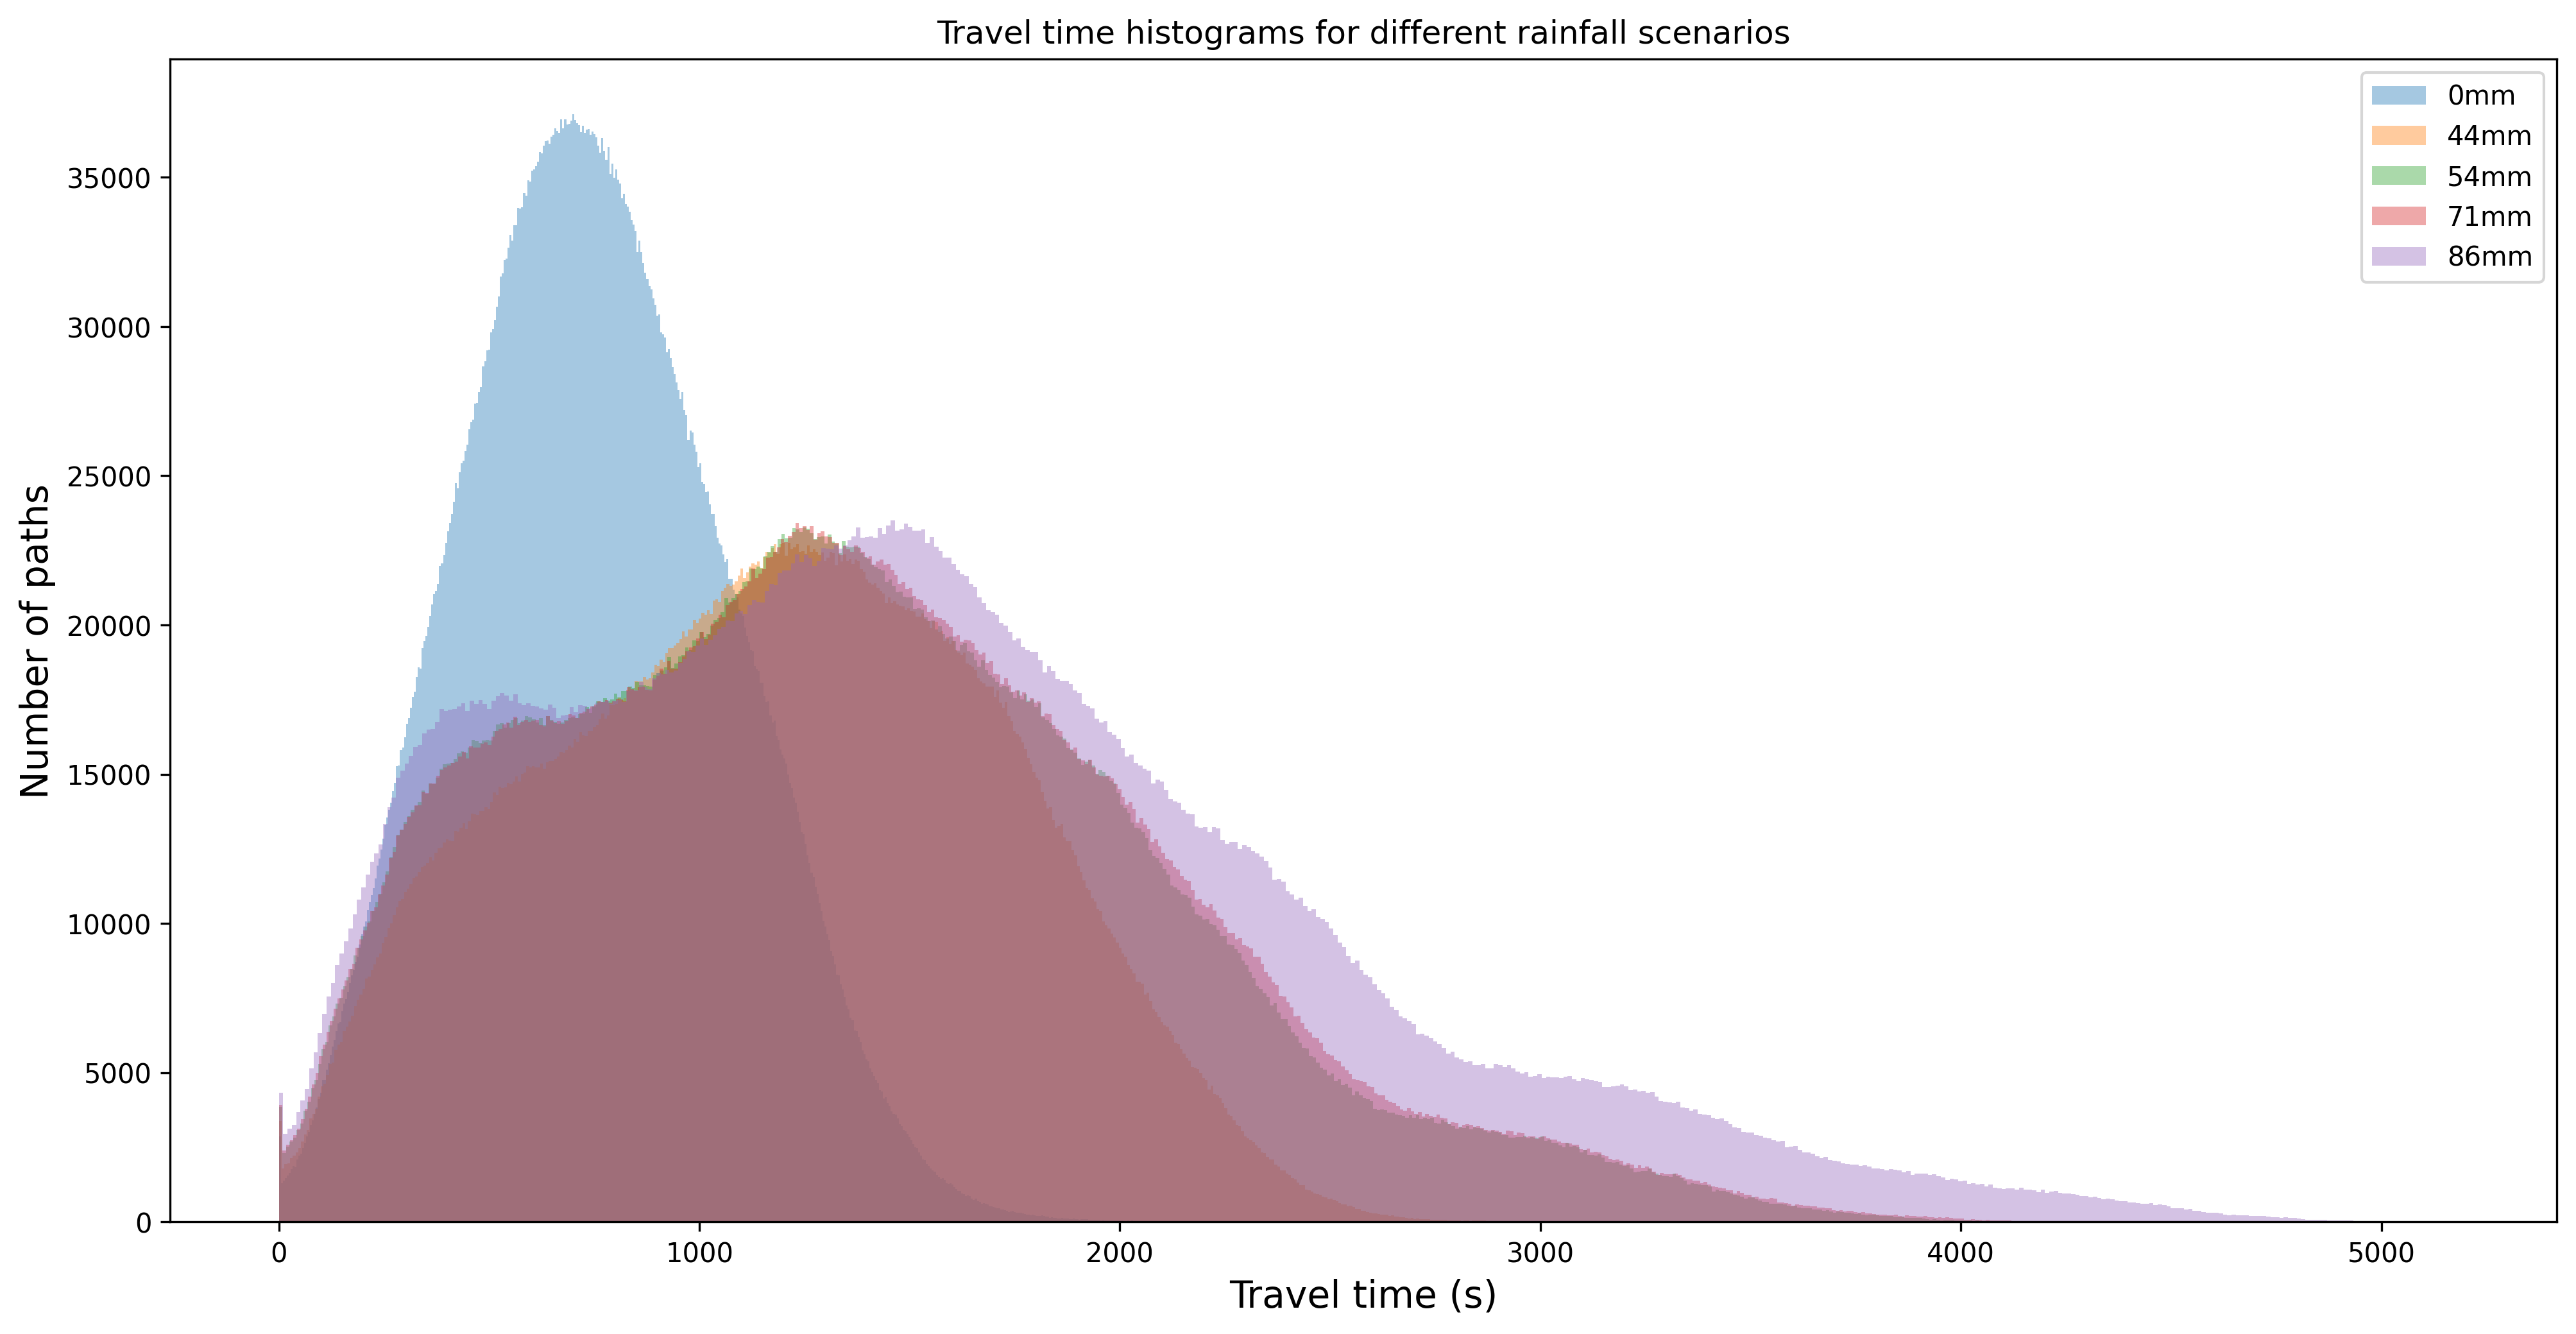

In [ ]:
# Histogram of travel times
plt.figure(figsize=(16,8), dpi=300)

for i in rain[:5]:
  hist_data = [i[0] for i in flooded_stats[str(i)]['od_weights'].values()]
  plt.hist(hist_data, bins=500, alpha=0.4, label=f'{i}mm')
plt.xlabel("Travel time (s)", size=14)
plt.ylabel("Number of paths", size=14)
plt.title("Travel time histograms for different rainfall scenarios")
plt.legend(loc='upper right')
#plt.savefig("Histograms-travel-time.svg", format='svg')

Text(0, 0.5, 'Travel time (s)')

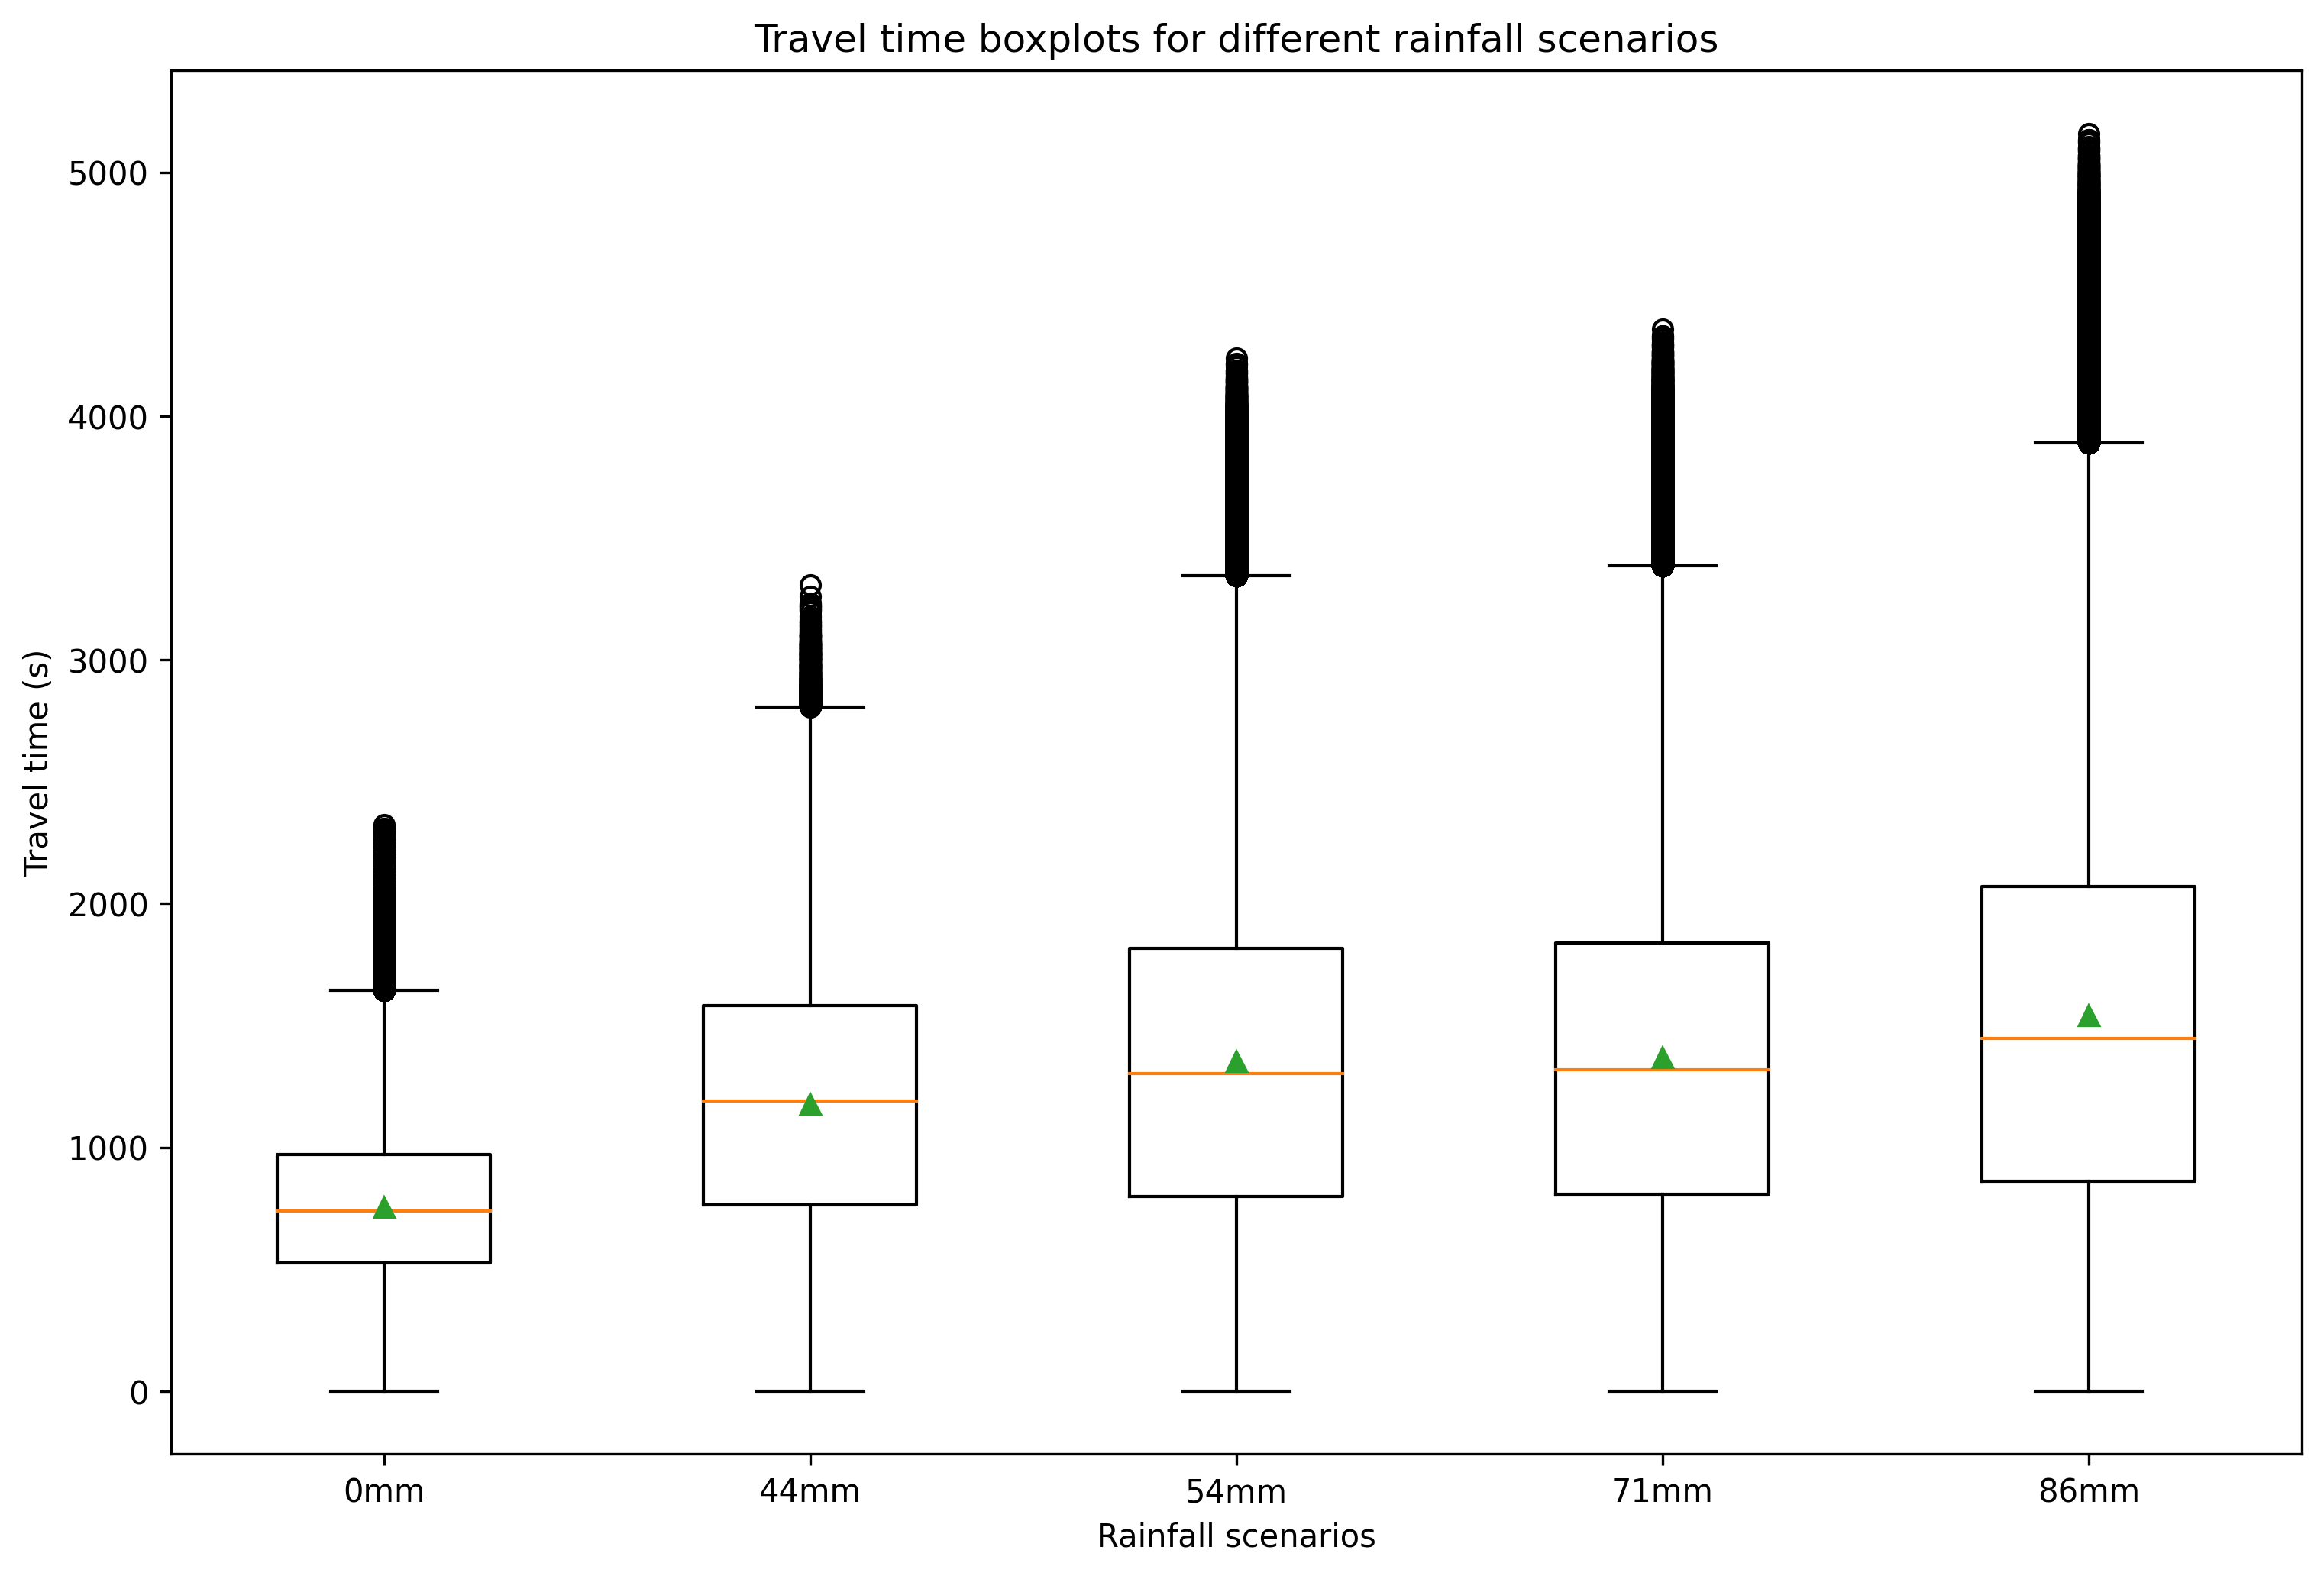

In [ ]:
box_data = {}
for i in rain[:5]:
  box_data[f'{i}mm'] = [i[0] for i in flooded_stats[str(i)]['od_weights'].values()]

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
fig.set_dpi(300)
ax.boxplot(box_data.values(), showmeans=True)
ax.set_xticklabels(box_data.keys())
ax.set_title('Travel time boxplots for different rainfall scenarios')
ax.set_xlabel('Rainfall scenarios')
ax.set_ylabel('Travel time (s)')
#plt.savefig("Boxplots-travel-time.png", format='png')

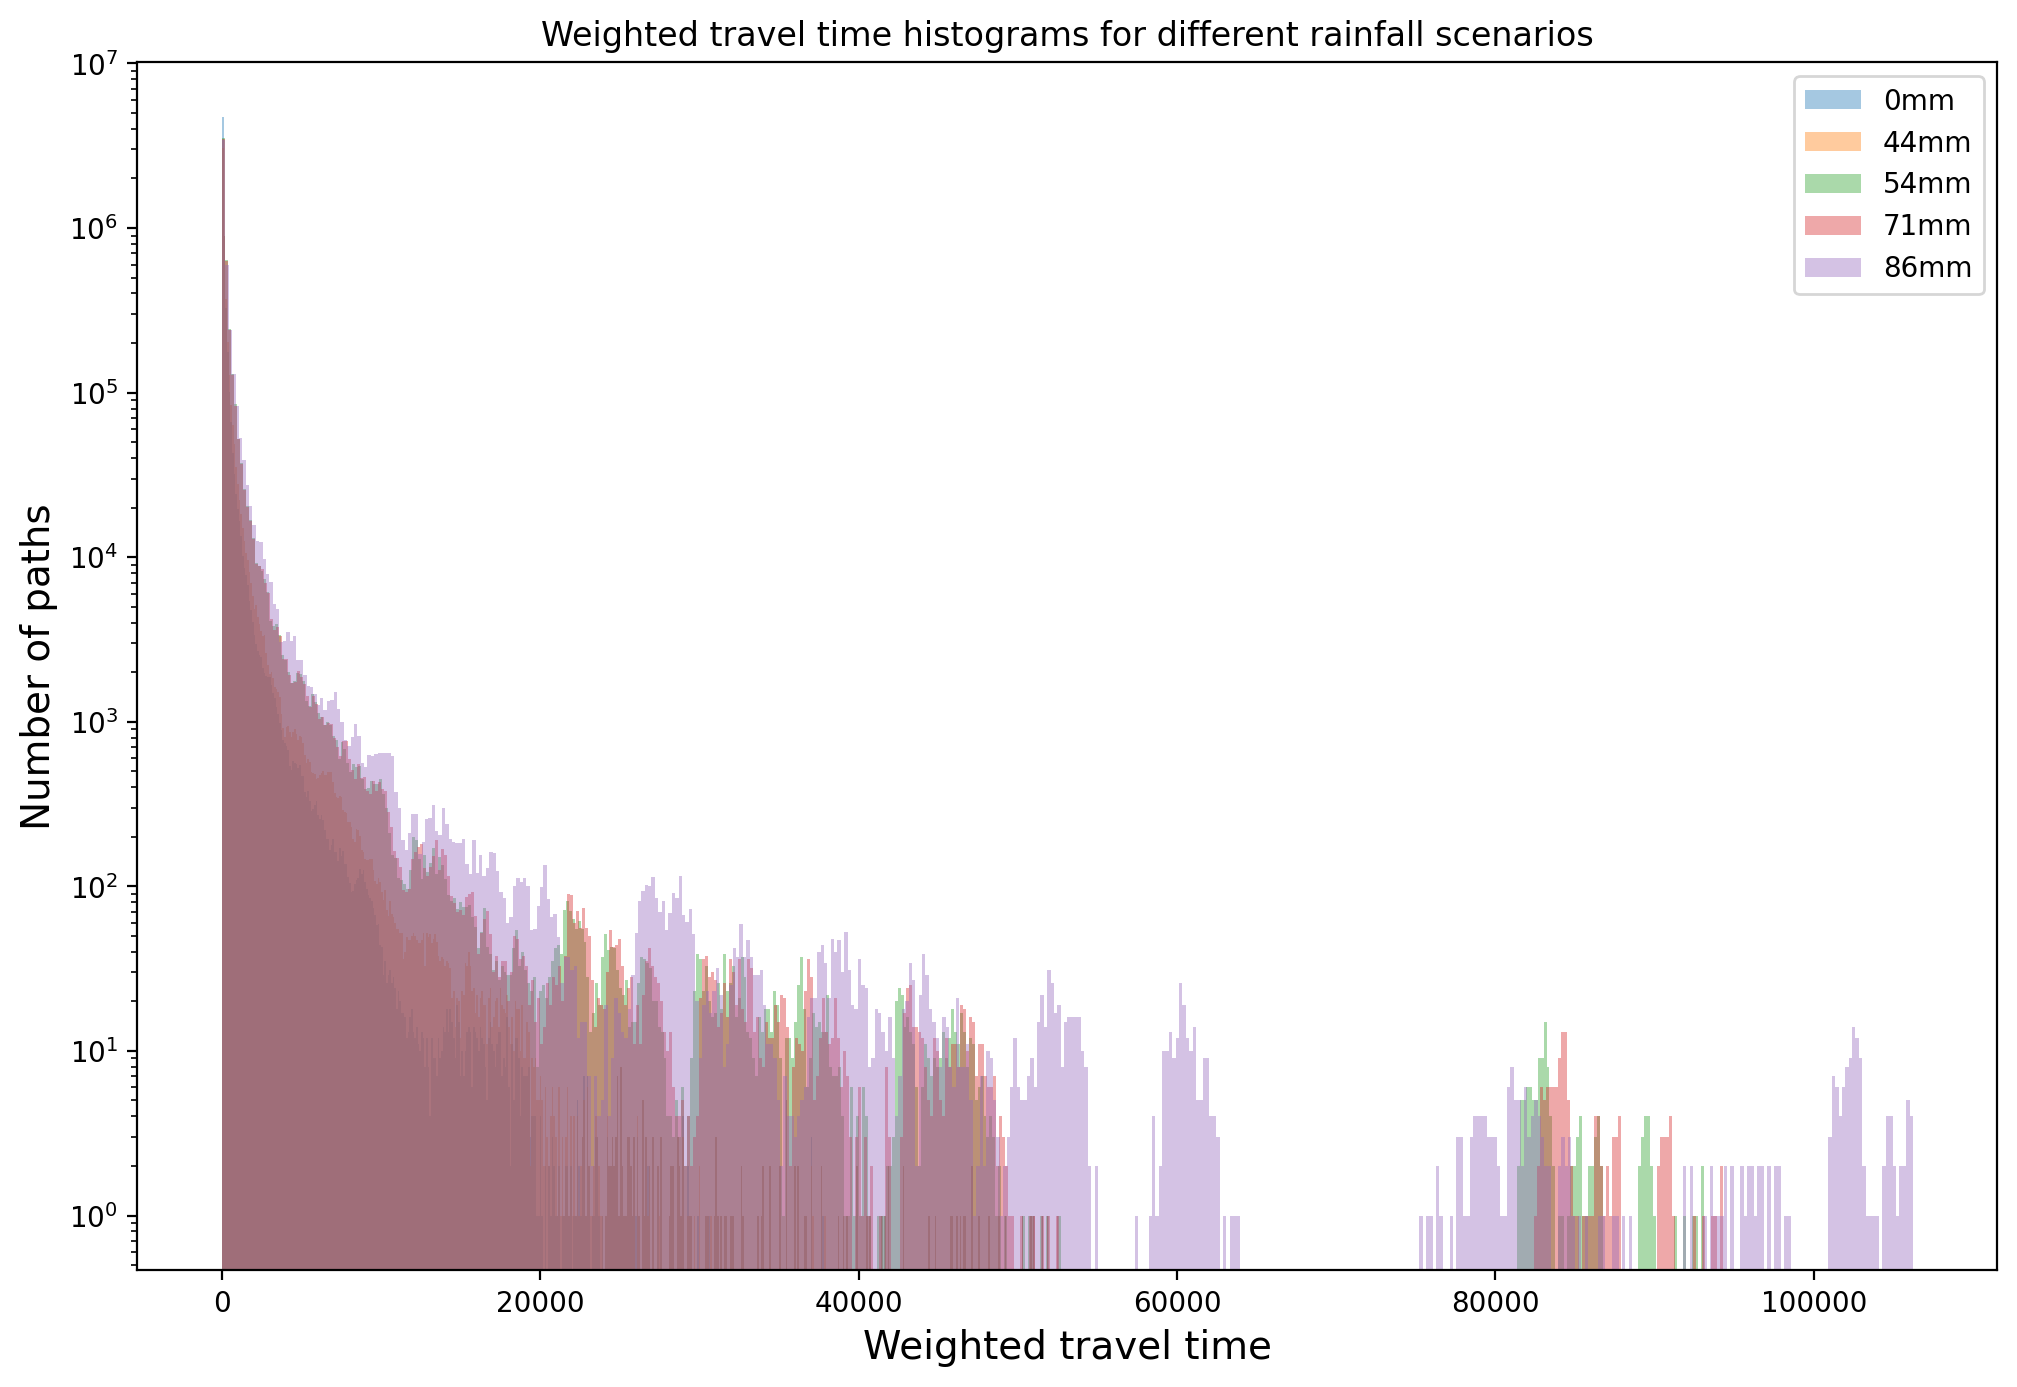

In [ ]:
# Histogram of weighted travel times
plt.figure(figsize=(12,8), dpi=200)

for i in rain[:5]:
  hist_data = [i[0]*i[1] for i in flooded_stats[str(i)]['od_weights'].values()]
  plt.hist(hist_data, bins=500, alpha=0.4, label=f'{i}mm')
plt.xlabel("Weighted travel time", size=14)
plt.yscale("log")
plt.ylabel("Number of paths", size=14)
plt.title("Weighted travel time histograms for different rainfall scenarios")
plt.legend(loc='upper right')
#plt.savefig(f'Histograms-weighted-travel-time-{tt_od_s}.svg', format='svg')

Text(0, 0.5, 'Weighted travel time (log scale)')

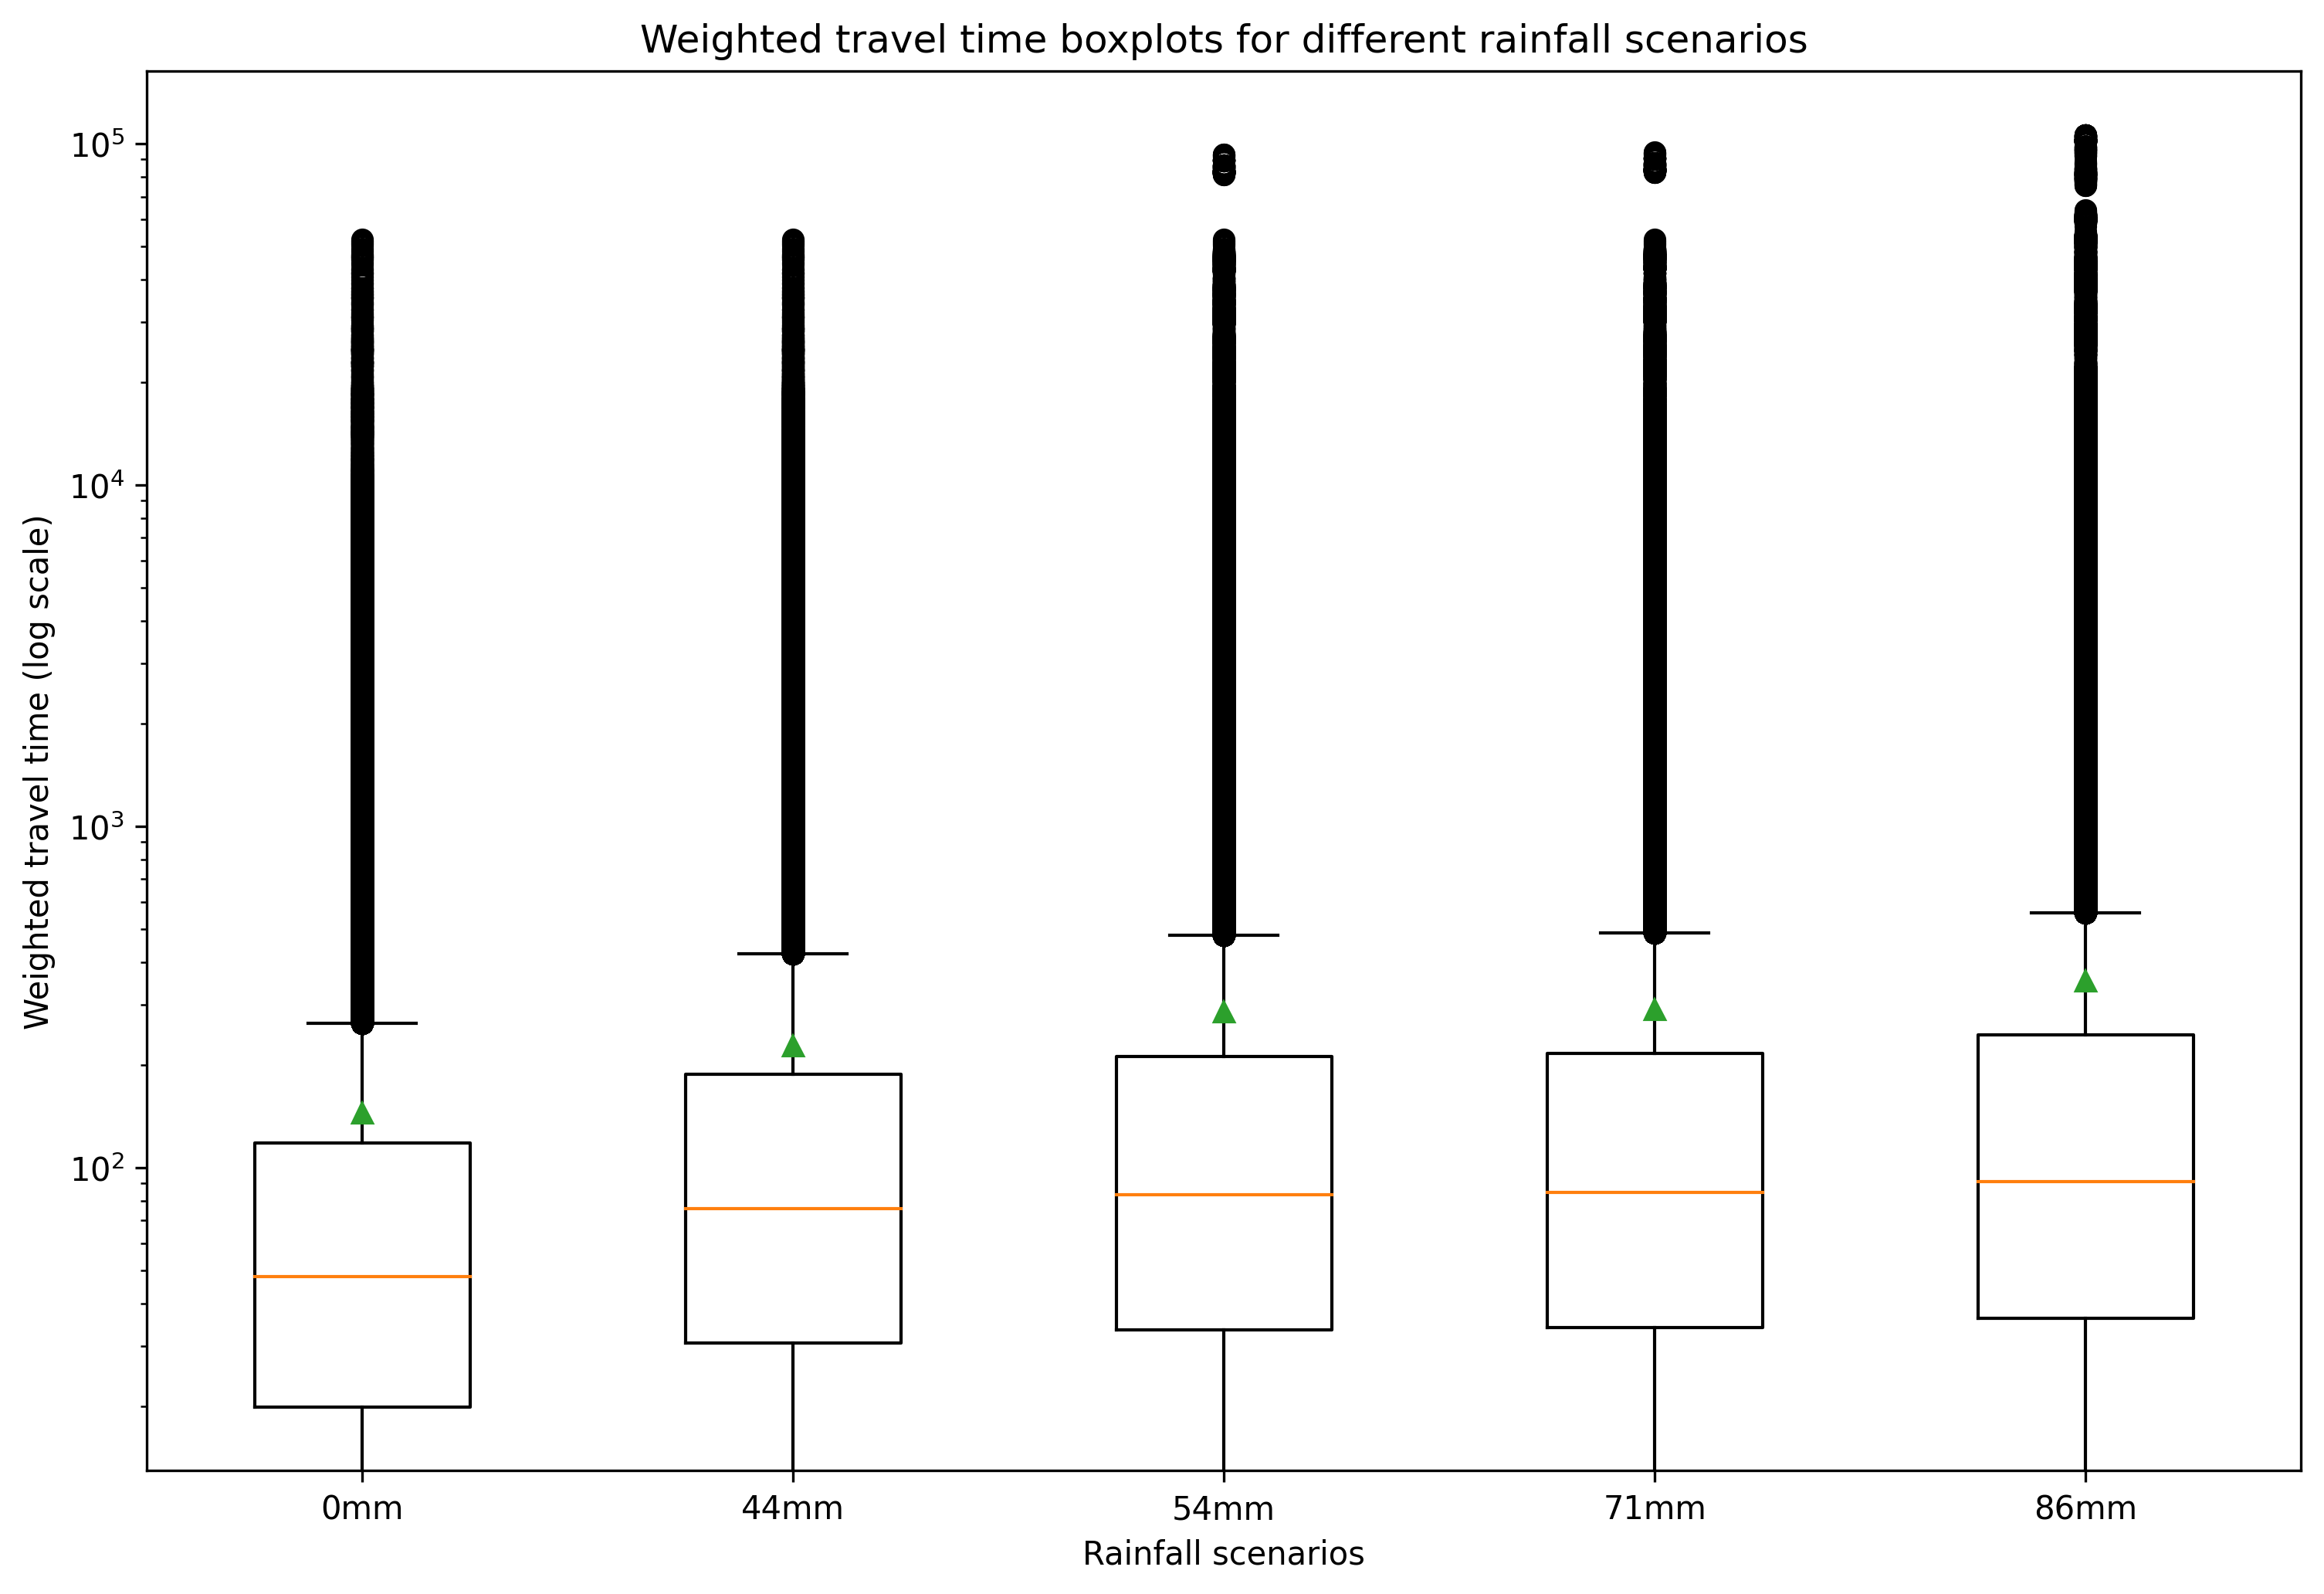

In [ ]:
box_data = {}
for i in rain[:5]:
  box_data[f'{i}mm'] = [i[0]*i[1] for i in flooded_stats[str(i)]['od_weights'].values()]

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
fig.set_dpi(300)
ax.boxplot(box_data.values(), showmeans=True)
ax.set_xticklabels(box_data.keys())
ax.set_yscale('log')
ax.set_title('Weighted travel time boxplots for different rainfall scenarios')
ax.set_xlabel('Rainfall scenarios')
ax.set_ylabel('Weighted travel time (log scale)')
#plt.savefig(f'Boxplots-weighted-travel-time-log-{tt_od_s}.png', format='png')

Text(0, 0.5, 'Weighted travel time')

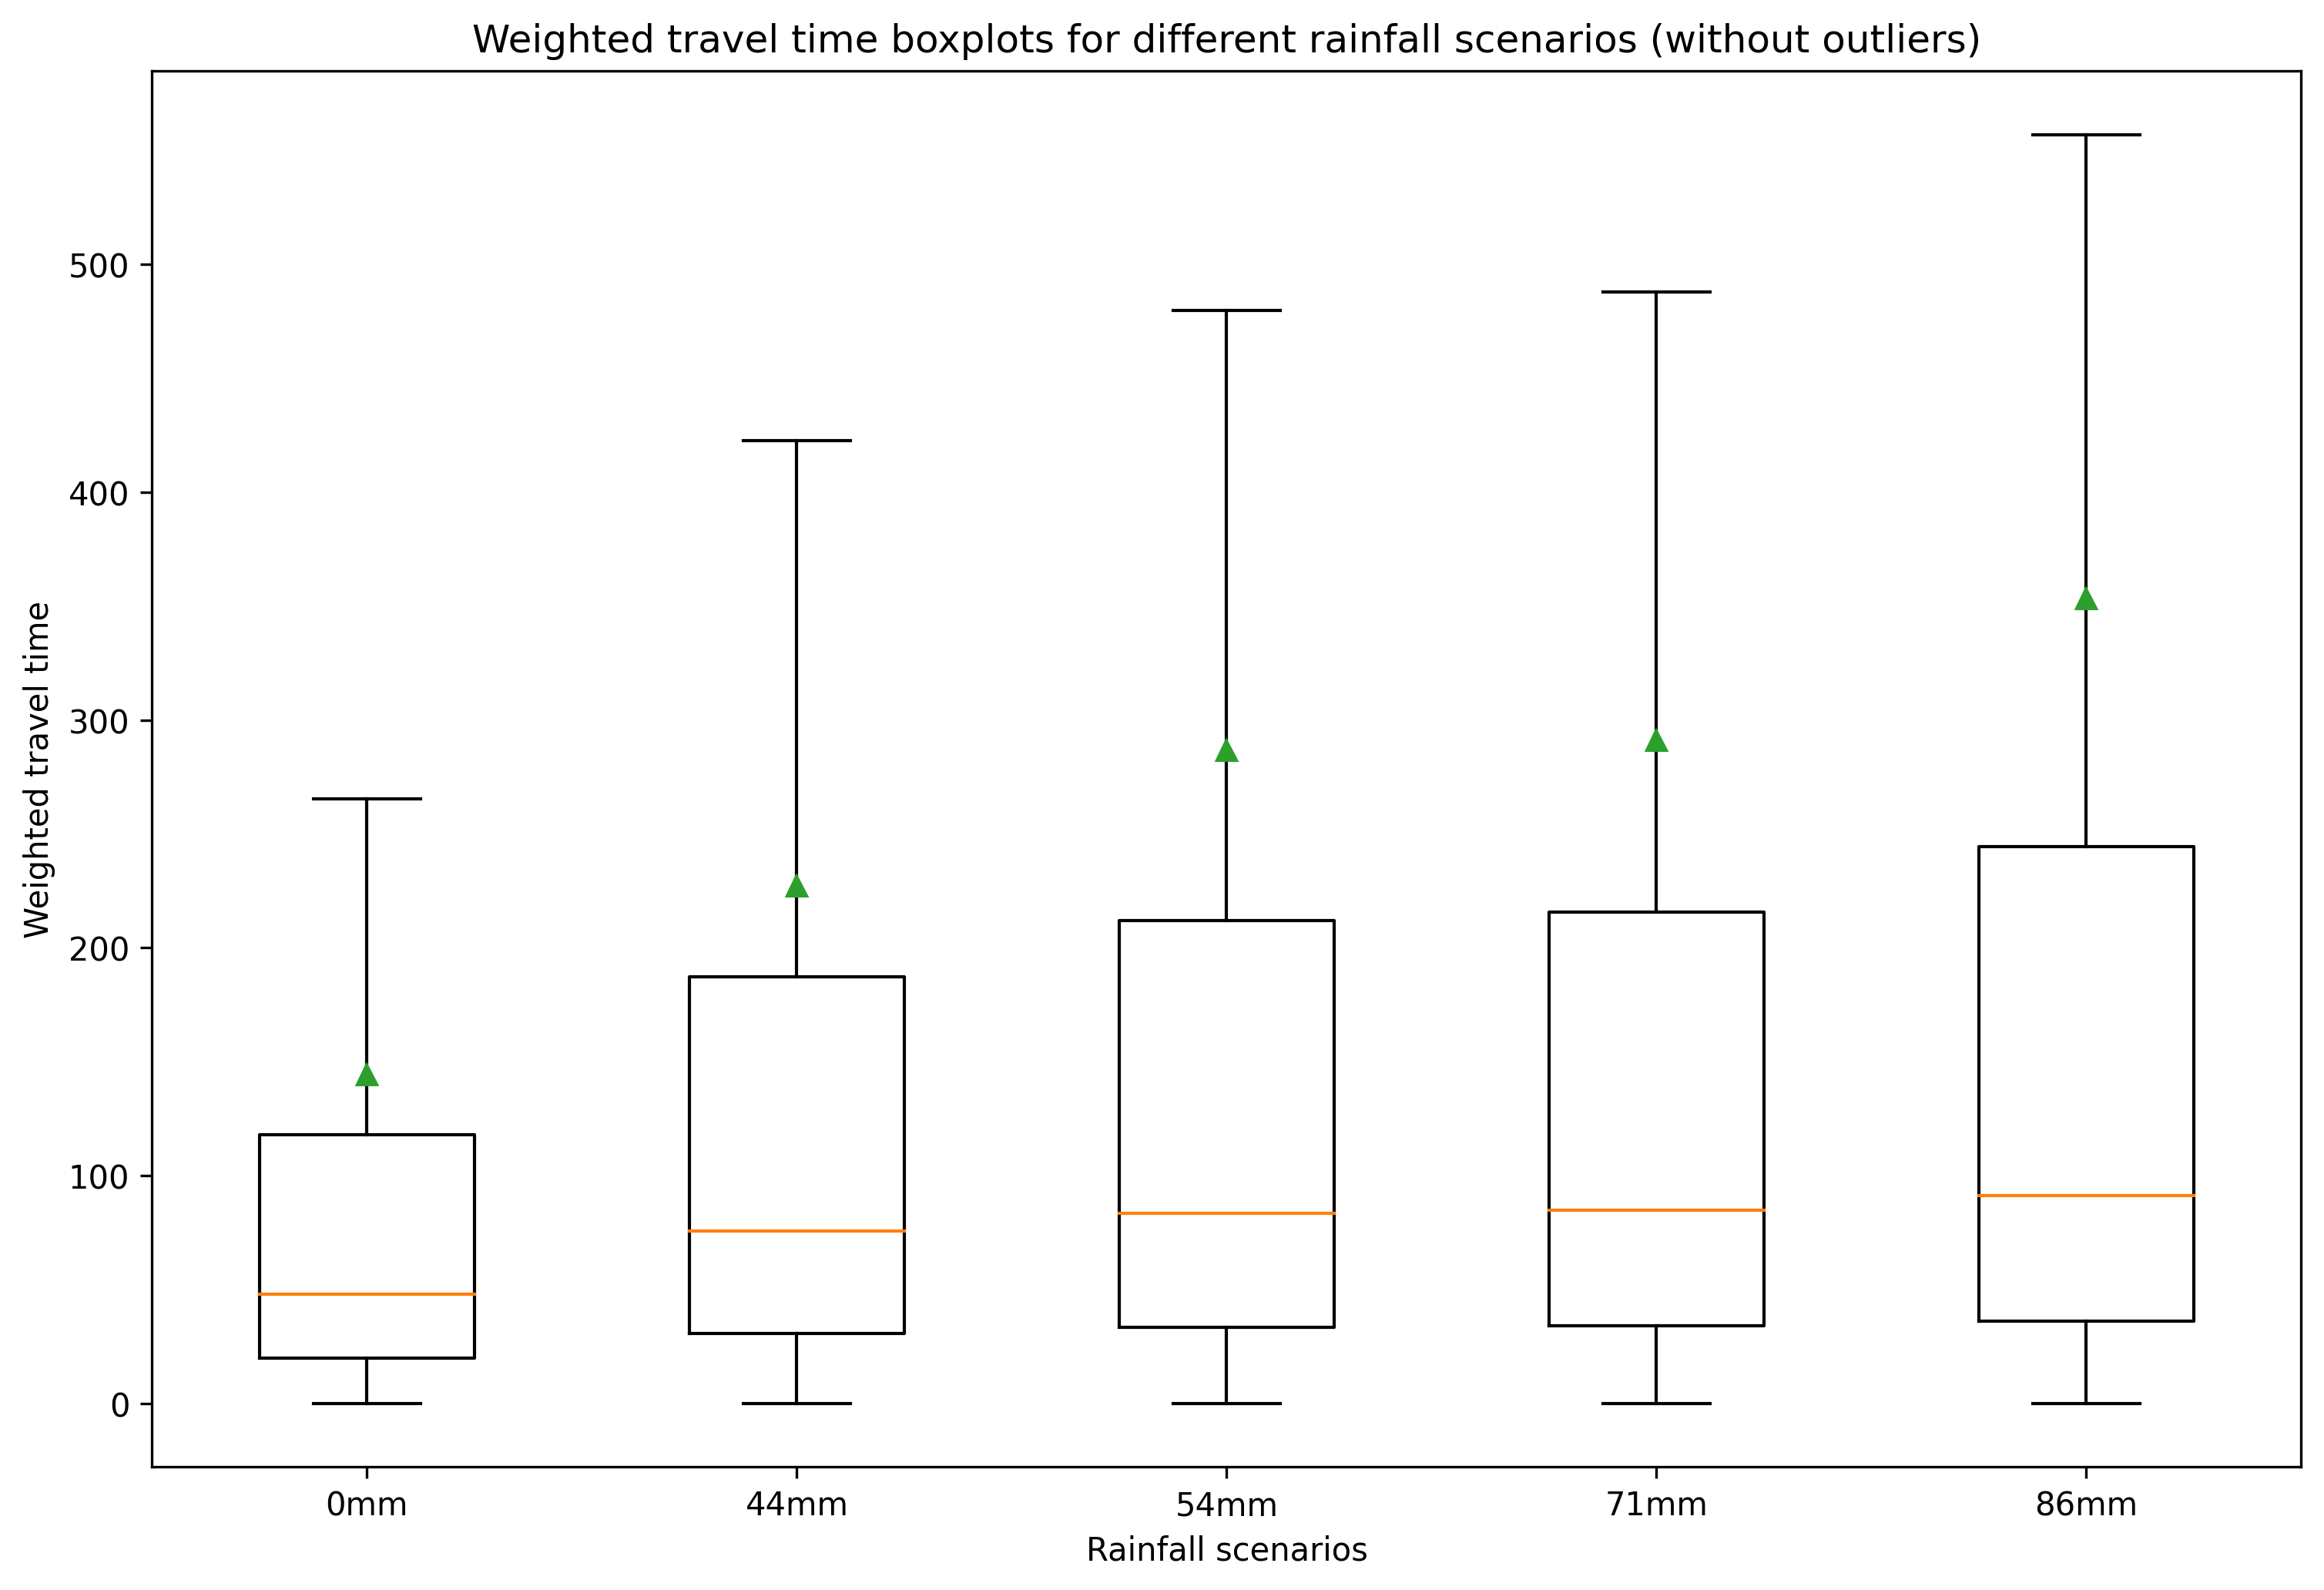

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
fig.set_dpi(300)
ax.boxplot(box_data.values(), showfliers=False, showmeans=True)
ax.set_xticklabels(box_data.keys())
ax.set_title('Weighted travel time boxplots for different rainfall scenarios (without outliers)')
ax.set_xlabel('Rainfall scenarios')
ax.set_ylabel('Weighted travel time')
#plt.savefig(f'Boxplots-weighted-travel-time-no-outliers-{tt_od_s}.svg', format='svg')

### Extreme values

In [ ]:
# 200 mm and 450 mm maximum drivable depth
drivable_depth = [0.20, 0.45]
flooded_graphs_ext = {}
flooded_stats_ext = {}

flooded_graphs_ext[0] = G2a
flooded_stats_ext[(0,0)] = default_stats
flooded_stats_ext[(0,0)]["mean_travel_time_id"] = default_stats["mean_travel_time"]
flooded_stats_ext[(0,0)] = flooded_stats_ext[(0,0)]['stats'] + [flooded_stats_ext[(0,0)]['mean_travel_time_id']]
print(f'Mean travel time with all routes: {default_stats["mean_travel_time"]:.3f} s')

for d in drivable_depth:
  print(f'\n### Drivable depth {d} m ###')
  rain = [44, 54, 71, 86, 20, 198]
  flooded_graphs_ext[d] = prepare_graph(G2a, drivable_depth=d, rain=rain)
  for i in rain:
    flooded_stats_ext[(d,i)] = analyse_graph(flooded_graphs_ext[d][str(i)], prints=False)
    flooded_stats_ext[(d,i)]["mean_travel_time_id"] = compare_travel_time(flooded_stats_ext[(d,i)], i)
    flooded_stats_ext[(d,i)] = flooded_stats_ext[(d,i)]['stats'] + [flooded_stats_ext[(d,i)]['mean_travel_time_id']]
    gc.collect()

Mean travel time with all routes: 491.511 s

### Drivable depth 0.2 m ###
Mean travel time on identical set of routes: 470.047 s, with 44mm rain: 927.278
Mean travel time on identical set of routes: 469.181 s, with 54mm rain: 965.370
Mean travel time on identical set of routes: 460.910 s, with 71mm rain: 973.183
Mean travel time on identical set of routes: 461.013 s, with 86mm rain: 971.831
Mean travel time on identical set of routes: 487.718 s, with 20mm rain: 729.272
Mean travel time on identical set of routes: 447.660 s, with 198mm rain: 945.690

### Drivable depth 0.45 m ###
Mean travel time on identical set of routes: 488.836 s, with 44mm rain: 625.743
Mean travel time on identical set of routes: 488.840 s, with 54mm rain: 644.423
Mean travel time on identical set of routes: 488.834 s, with 71mm rain: 701.885
Mean travel time on identical set of routes: 488.794 s, with 86mm rain: 726.566
Mean travel time on identical set of routes: 491.090 s, with 20mm rain: 563.724
Mean travel ti

In [ ]:
flooded_stats_df = pd.DataFrame.from_dict(flooded_stats_ext, orient='index', columns=['Trips possible' , 'Total travel time', 'Mean Travel time', 'Available paths', 'Unavailable paths', 'Trips impossible', 'Trips total', 'Nodes', 'Isolated nodes', 'Edges', 'Mean travel time (id. set)'])
#flooded_stats_df.to_csv(f'flooded_stats-ext-{tt_od_s}.csv')
flooded_stats_df.round(2)

,Trips possible,Total travel time,Mean Travel time,Available paths,Unavailable paths,Trips impossible,Trips total,Nodes,Isolated nodes,Edges,Mean travel time (id. set)
"(0, 0)",1911281.25,9.394154e+08,491.51,6505175,187394,137566.75,2048848,2587,0,5509,491.51
"(0.2, 44)",1316750.14,1.220994e+09,927.28,4210583,2481986,732097.86,2048848,2587,71,4843,470.05
"(0.2, 54)",1298656.01,1.253684e+09,965.37,4088593,2603976,750191.99,2048848,2587,75,4817,469.18
"(0.2, 71)",1251482.77,1.217922e+09,973.18,3883977,2808592,797365.23,2048848,2587,83,4779,460.91
"(0.2, 86)",1230728.37,1.196060e+09,971.83,3793093,2899476,818119.63,2048848,2587,93,4750,461.01
"(0.2, 20)",1646967.82,1.201088e+09,729.27,5366023,1326546,401880.18,2048848,2587,46,4989,487.72
"(0.2, 198)",1092804.71,1.033455e+09,945.69,2825794,3866775,956043.29,2048848,2587,129,4652,447.66
"(0.45, 44)",1748357.69,1.094022e+09,625.74,5649484,1043085,300490.31,2048848,2587,33,5139,488.84
"(0.45, 54)",1732399.56,1.116397e+09,644.42,5568963,1123606,316448.44,2048848,2587,35,5122,488.84
"(0.45, 71)",1692237.52,1.187756e+09,701.88,5360761,1331808,356610.48,2048848,2587,40,5072,488.83
